#### Aquí encontrarás todo lo que necesitas saber: https://www.kaggle.com/competitions/desafio-de-prediccion-de-precios-de-portatiles

## Librerias

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.font_manager
import bootcampviztools as bt
import statsmodels.api as sm
import warnings
import sklearn
import os
import cv2
import re


from matplotlib import style
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.feature_selection import SelectKBest, f_classif, SelectFromModel, RFE, SequentialFeatureSelector
from sklearn.linear_model import LinearRegression, LogisticRegression, ElasticNet
from sklearn.metrics import classification_report, ConfusionMatrixDisplay,  mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, silhouette_score, silhouette_samples, mutual_info_score
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV, cross_val_predict
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, LabelEncoder, scale
from matplotlib.ticker import FixedLocator, FixedFormatter
from sklearn.tree import DecisionTreeClassifier,DecisionTreeRegressor
from sklearn.utils import resample
from scipy import stats
from scipy.stats import mannwhitneyu


from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from xgboost import XGBClassifier, XGBRegressor
from lightgbm import LGBMClassifier, LGBMRegressor
from catboost import CatBoostClassifier, CatBoostRegressor


warnings.filterwarnings('ignore')
style.use('ggplot') or plt.style.use('ggplot')

## Data

In [2]:
### Para que funcione necesitas bajarte los archivos de datos de Kaggle 
pcs = pd.read_csv("./data/train.csv")

## Data exploration

In [3]:
pcs.head()

,id,laptop_ID,Company,Product,TypeName,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,Weight,Price_euros
0,268,1002,Dell,Inspiron 5567,Notebook,15.6,1366x768,Intel Core i7 7500U 2.7GHz,8GB,1TB HDD,AMD Radeon R7 M445,Windows 10,2.36kg,749.00
1,347,867,Asus,X541NA (N4200/4GB/1TB/W10),Notebook,15.6,1366x768,Intel Pentium Quad Core N4200 1.1GHz,4GB,1TB HDD,Intel HD Graphics 505,Windows 10,2kg,449.00
2,353,966,Toshiba,Portege Z30-C-1CW,Notebook,13.3,Full HD 1920x1080,Intel Core i5 6200U 2.3GHz,8GB,256GB SSD,Intel HD Graphics 520,Windows 7,1.2kg,1460.00
3,578,767,Dell,Alienware 17,Gaming,15.6,IPS Panel 4K Ultra HD 3840x2160,Intel Core i7 7700HQ 2.8GHz,16GB,256GB SSD + 1TB HDD,Nvidia GeForce GTX 1070,Windows 10,4.42kg,2868.99
4,42,1241,Dell,Latitude E7270,Ultrabook,12.5,Full HD / Touchscreen 1920x1080,Intel Core i5 6300U 2.4GHz,8GB,256GB SSD,Intel HD Graphics 520,Windows 7,1.26kg,1713.37


In [4]:
pcs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 912 entries, 0 to 911
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                912 non-null    int64  
 1   laptop_ID         912 non-null    int64  
 2   Company           912 non-null    object 
 3   Product           912 non-null    object 
 4   TypeName          912 non-null    object 
 5   Inches            912 non-null    float64
 6   ScreenResolution  912 non-null    object 
 7   Cpu               912 non-null    object 
 8   Ram               912 non-null    object 
 9   Memory            912 non-null    object 
 10  Gpu               912 non-null    object 
 11  OpSys             912 non-null    object 
 12  Weight            912 non-null    object 
 13  Price_euros       912 non-null    float64
dtypes: float64(2), int64(2), object(10)
memory usage: 99.9+ KB


In [5]:
# No hay nulos, bien!
# numéricas hay apenas 4 (las 2 de IF, las inches y el precio, que es el target)
# Tenemos una gran parte de variables categóricas que habrá que procesar y transformar en numéricas

In [6]:
pcs.describe()

,id,laptop_ID,Inches,Price_euros
count,912.000000,912.000000,912.000000,912.000000
mean,645.091009,666.192982,15.011404,1108.122873
std,380.313813,384.873846,1.411744,714.597741
min,0.000000,1.000000,10.100000,174.000000
25%,319.750000,330.500000,14.000000,589.000000
50%,636.500000,673.500000,15.600000,949.000000
75%,980.250000,998.500000,15.600000,1458.500000
max,1302.000000,1320.000000,18.400000,6099.000000


In [7]:
target = "Price_euros"

In [8]:
pcs["Company"].value_counts()

Company
Lenovo       208
Dell         207
HP           189
Asus         108
Acer          75
Toshiba       37
MSI           34
Apple         17
Mediacom       7
Razer          6
Samsung        6
Fujitsu        3
Microsoft      3
Vero           3
Xiaomi         3
Google         2
Chuwi          2
LG             1
Huawei         1
Name: count, dtype: int64

In [9]:
pcs["Product"].value_counts()

Product
Inspiron 3567                                21
XPS 13                                       20
250 G6                                       19
Vostro 3568                                  16
Inspiron 5570                                11
                                             ..
Elitebook Folio                               1
Q304UA-BHI5T11 (i5-7200U/6GB/1TB/FHD/W10)     1
ThinkPad T470p                                1
V310-15IKB (i5-7200U/4GB/1TB/No               1
Portege Z30-C-16H                             1
Name: count, Length: 475, dtype: int64

In [10]:
pcs["Product"].value_counts().unique()

array([21, 20, 19, 16, 11, 10,  9,  8,  7,  6,  5,  4,  3,  2,  1],
      dtype=int64)

In [11]:
pcs["TypeName"].value_counts()

TypeName
Notebook              522
Gaming                138
Ultrabook             135
2 in 1 Convertible     85
Workstation            18
Netbook                14
Name: count, dtype: int64

In [12]:
pcs["Inches"].value_counts()

Inches
15.6    474
14.0    143
13.3    111
17.3    108
12.5     28
11.6     21
12.0      6
10.1      4
13.9      4
15.4      3
15.0      3
13.5      3
12.3      2
13.0      1
18.4      1
Name: count, dtype: int64

<Axes: >

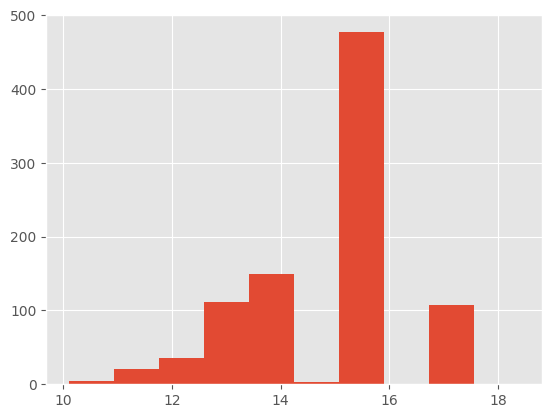

In [13]:
pcs["Inches"].hist()

In [14]:
pcs["ScreenResolution"].value_counts()

ScreenResolution
Full HD 1920x1080                                346
1366x768                                         208
IPS Panel Full HD 1920x1080                      163
IPS Panel Full HD / Touchscreen 1920x1080         37
Full HD / Touchscreen 1920x1080                   32
Touchscreen 1366x768                              15
1600x900                                          11
IPS Panel 4K Ultra HD 3840x2160                   10
4K Ultra HD / Touchscreen 3840x2160                8
Quad HD+ / Touchscreen 3200x1800                   8
IPS Panel 4K Ultra HD / Touchscreen 3840x2160      8
IPS Panel Retina Display 2304x1440                 6
IPS Panel Retina Display 2560x1600                 5
IPS Panel 1366x768                                 5
4K Ultra HD 3840x2160                              5
IPS Panel Touchscreen 1920x1200                    4
Touchscreen 2560x1440                              4
IPS Panel Quad HD+ / Touchscreen 3200x1800         4
IPS Panel Touchscreen 2560x14

In [15]:
pcs["Cpu"].value_counts()

Cpu
Intel Core i5 7200U 2.5GHz     142
Intel Core i7 7700HQ 2.8GHz    102
Intel Core i7 7500U 2.7GHz      88
Intel Core i5 8250U 1.6GHz      54
Intel Core i5 6200U 2.3GHz      51
                              ... 
Intel Core i7 7660U 2.5GHz       1
AMD E-Series E2-9000 2.2GHz      1
Intel Core i3 6006U 2.2GHz       1
Intel Core i7 2.8GHz             1
AMD E-Series 9000 2.2GHz         1
Name: count, Length: 104, dtype: int64

In [16]:
pcs["Cpu"].unique()

array(['Intel Core i7 7500U 2.7GHz',
       'Intel Pentium Quad Core N4200 1.1GHz',
       'Intel Core i5 6200U 2.3GHz', 'Intel Core i7 7700HQ 2.8GHz',
       'Intel Core i5 6300U 2.4GHz', 'Intel Core i3 6006U 2GHz',
       'Intel Pentium Quad Core N3710 1.6GHz',
       'Intel Core i7 8550U 1.8GHz', 'AMD A9-Series A9-9420 3GHz',
       'Intel Pentium Dual Core 4405U 2.1GHz',
       'Intel Core i5 8250U 1.6GHz', 'Intel Core i3 7100U 2.4GHz',
       'Intel Core i5 7200U 2.5GHz', 'Intel Xeon E3-1535M v6 3.1GHz',
       'Intel Atom x5-Z8550 1.44GHz', 'AMD A10-Series 9620P 2.5GHz',
       'Intel Core i5 7300U 2.6GHz',
       'Intel Celeron Dual Core N3350 1.1GHz',
       'Intel Core i7 6500U 2.5GHz', 'Intel Core i3 6006U 2.0GHz',
       'Intel Celeron Dual Core 3205U 1.5GHz',
       'AMD A12-Series 9720P 3.6GHz',
       'Intel Celeron Dual Core N3050 1.6GHz',
       'Intel Core i3 7130U 2.7GHz', 'Intel Core i5 7300HQ 2.5GHz',
       'Intel Core i5 7200U 2.7GHz', 'Intel Core i7 7820HQ 2.9GHz

In [17]:
pcs["Ram"].value_counts()

Ram
8GB     434
4GB     274
16GB    125
6GB      32
2GB      16
12GB     15
32GB     14
24GB      2
Name: count, dtype: int64

In [18]:
pcs["Memory"].value_counts()

Memory
256GB SSD                        293
1TB HDD                          150
500GB HDD                        100
512GB SSD                         75
128GB SSD +  1TB HDD              61
128GB SSD                         56
256GB SSD +  1TB HDD              52
32GB Flash Storage                27
64GB Flash Storage                11
2TB HDD                           11
512GB SSD +  1TB HDD              10
1TB SSD                            9
1.0TB Hybrid                       7
256GB Flash Storage                7
32GB SSD                           5
180GB SSD                          5
256GB SSD +  2TB HDD               4
16GB Flash Storage                 4
16GB SSD                           3
256GB SSD +  500GB HDD             2
1TB SSD +  1TB HDD                 2
128GB Flash Storage                2
512GB SSD +  2TB HDD               2
512GB Flash Storage                2
1.0TB HDD                          1
32GB HDD                           1
128GB SSD +  2TB HDD           

In [19]:
pcs["Gpu"].value_counts()

Gpu
Intel HD Graphics 620      199
Intel HD Graphics 520      138
Intel UHD Graphics 620      45
Nvidia GeForce GTX 1050     43
Nvidia GeForce GTX 1060     31
                          ... 
Nvidia GeForce 920MX         1
Intel HD Graphics 620        1
AMD Radeon R7 M365X          1
Nvidia Quadro M2200M         1
Nvidia Quadro M520M          1
Name: count, Length: 91, dtype: int64

In [20]:
pcs["OpSys"].value_counts()

OpSys
Windows 10      746
Linux            47
No OS            44
Windows 7        32
Chrome OS        20
macOS            11
Mac OS X          6
Windows 10 S      4
Android           2
Name: count, dtype: int64

In [21]:
pcs["Weight"].value_counts()

Weight
2.2kg     86
2.1kg     40
2.3kg     35
2.4kg     31
2kg       30
          ..
4.0kg      1
0.98kg     1
3.6kg      1
2.99kg     1
1.79kg     1
Name: count, Length: 158, dtype: int64

## Data processing

In [22]:
# Separación train y test

In [23]:
var_desc = ["laptop_ID", "Product"] 
pcs = pcs.drop(["laptop_ID", "Product"], axis=1) 

X = pcs.drop("Price_euros", axis=1) 
y = pcs["Price_euros"] 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [24]:
len(X_train)

729

In [25]:
len(X_test)

183

### Mini EDA

In [26]:
pcs_eda = pd.concat([X_train, y_train], axis=1)

target = "Price_euros"
var_categ = []
var_num = [] 
var_sec = []

In [27]:
# Para inches solo comprobamos que sea nummérica
pcs_eda['Inches'] = pcs_eda['Inches'].astype(float)
var_num.append("Inches")

In [28]:
var_categ.append("OpSys")
var_categ.append("TypeName")

In [29]:
# Primero tenemos que hacer unas ligeras transformaciones para que las columnas tengan el tipo de valor que necesitamos, sea categórico, numérico, etc

In [30]:
# Transformar la columna 'Company'
marcas_ppales = pcs_eda['Company'].value_counts().sort_values(ascending=False) / pcs_eda['Company'].count()
top_10_companies = marcas_ppales[marcas_ppales >= 0.01].index.tolist()
otras_marcas = [company for company in pcs_eda['Company'].unique() if company not in top_10_companies]
pcs_eda['Company'] = pcs_eda['Company'].replace(otras_marcas, "Otra")
var_categ.append("Company")

In [31]:
# Transformar la columna 'Weight'
pcs_eda['Weight'] = pcs_eda['Weight'].apply(lambda x: float(x.replace('kg', '').replace(',', '.')))
var_num.append("Weight")

In [32]:
# Transformar la columna 'Ram'
pcs_eda['Ram'] = pcs_eda['Ram'].apply(lambda x: int(x.replace('GB', '')))
var_num.append("Ram")

In [33]:
# Y las que hay que procesar un poco más: 'ScreenResolution', 'Cpu', 'Memory', 'Gpu', de las quw voy a sacar varias columnas, sean categóricas o numéricas

In [68]:
# Transformar la columna 'ScreenResolution'
def extract_screen_resolution(df):
    def extract_resolution(s):
        match = re.search(r'(\d{3,4})x(\d{3,4})', s)
        if match:
            return int(match.group(1)) * int(match.group(2))
        else:
            return None

    # Aplicar la función para extraer la resolución de la pantalla y crear la nueva columna 'SCR_resol'
    df['SCR_resol'] = df['ScreenResolution'].apply(extract_resolution)
    num_cols.append("SCR_resol")  # Agregar 'SCR_resol' a las columnas numéricas

    # Lista de etiquetas de características de pantalla
    labels = ['Touchscreen', 'FullHD', 'Retina', 'HD+', '4K', 'IPS Panel']

    # Iterar sobre cada etiqueta y generar la columna correspondiente
    for label in labels:
        if label == 'FullHD':
            df[f'SCR_{label}'] = df['ScreenResolution'].str.contains(r'\bFull\s*HD\b').astype(int)
        else:
            df[f'SCR_{label}'] = df['ScreenResolution'].str.contains(label).astype(int)
        num_cols.append(f'SCR_{label}')  # Agregar estas columnas a las columnas numéricas
    return df

# Verificar si 'SCR_FullHD' está presente en el DataFrame pcs_eda
print('SCR_FullHD' in pcs_eda.columns)

True


In [35]:
# Transformar la columna 'Cpu'
def extract_cpu_info(cpu):
    brand_pattern = r'(Intel|AMD)'
    speed_pattern = r'(\d+\.\d+)GHz'
    model_pattern = r'\b(?:Core [iI]\d+|Ryzen \d+)\b'
    series_pattern = r'(?:Intel|AMD)(.*?)\b(?:Core [iI]\d+|Ryzen \d+|$)'

    brand_match = re.search(brand_pattern, cpu)
    brand = brand_match.group(1) if brand_match else None

    speed_match = re.search(speed_pattern, cpu)
    speed = float(speed_match.group(1)) if speed_match else None

    model_match = re.search(model_pattern, cpu)
    model = model_match.group() if model_match else None

    series_match = re.search(series_pattern, cpu)
    series = series_match.group(1).strip() if series_match else None

    return brand, speed, model, series

pcs_eda['CPU_marca'], pcs_eda['CPU_velocidad'], pcs_eda['CPU_modelo'], pcs_eda['CPU_serie'] = zip(*pcs_eda['Cpu'].apply(extract_cpu_info))
var_categ.append("CPU_marca")
var_num.append("CPU_velocidad")
var_categ.append("CPU_modelo")
var_categ.append("CPU_serie")


In [36]:
# Transformar la columna 'Memory'
def extract_memory_info(memory):
    memory_pattern = r'(\d+)\s*(?:GB|T|TB)'
    keyword_pattern = r'HDD|SSD|Flash Storage|Hybrid'

    match = re.findall(memory_pattern, memory)
    if match:
        memory_value = int(match[0][0]) * 1024 if 'T' in memory else int(match[0][0])
    else:
        memory_value = 0

    keywords = re.findall(keyword_pattern, memory)
    storage_dict = {'HDD': 0, 'SSD': 0, 'Flash Storage': 0, 'Hybrid': 0}
    for keyword in keywords:
        storage_dict[keyword] = memory_value

    return storage_dict['HDD'], storage_dict['SSD'], storage_dict['Flash Storage'], storage_dict['Hybrid']

pcs_eda['Memo_HDD'], pcs_eda['Memo_SSD'], pcs_eda['Memo_Flash'], pcs_eda['Memo_Hybrid'] = zip(*pcs_eda['Memory'].apply(extract_memory_info))
pcs_eda.rename(columns={'Memo_HDD': 'Memo_HDD_GB', 'Memo_SSD': 'Memo_SSD_GB', 'Memo_Flash': 'Memo_Flash_GB', 'Memo_Hybrid': 'Memo_Hybrid_GB'}, inplace=True)
var_num.append("Memo_HDD_GB")
var_num.append("Memo_SSD_GB")
var_num.append("Memo_Flash_GB")
var_num.append("Memo_Hybrid_GB")

In [37]:
# Transformar la columna 'Gpu'
def extract_gpu_info(gpu):
    gpu_parts = gpu.split()
    gpu_brand = gpu_parts[0]
    gpu_model = None
    for part in gpu_parts:
        if any(char.isdigit() for char in part):
            gpu_model = ''.join(filter(str.isdigit, part))
            break
    gpu_family = ' '.join(gpu_parts[1:]) if gpu_model else ' '.join(gpu_parts[1:])
    return gpu_brand, gpu_model, gpu_family

pcs_eda['GPU_marca'], pcs_eda['GPU_modelo'], pcs_eda['GPU_familia'] = zip(*pcs_eda['Gpu'].apply(extract_gpu_info))
var_categ.append("GPU_marca")
var_num.append("GPU_modelo")
var_categ.append("GPU_familia")

In [38]:
# A ver la distribución de las numéricas

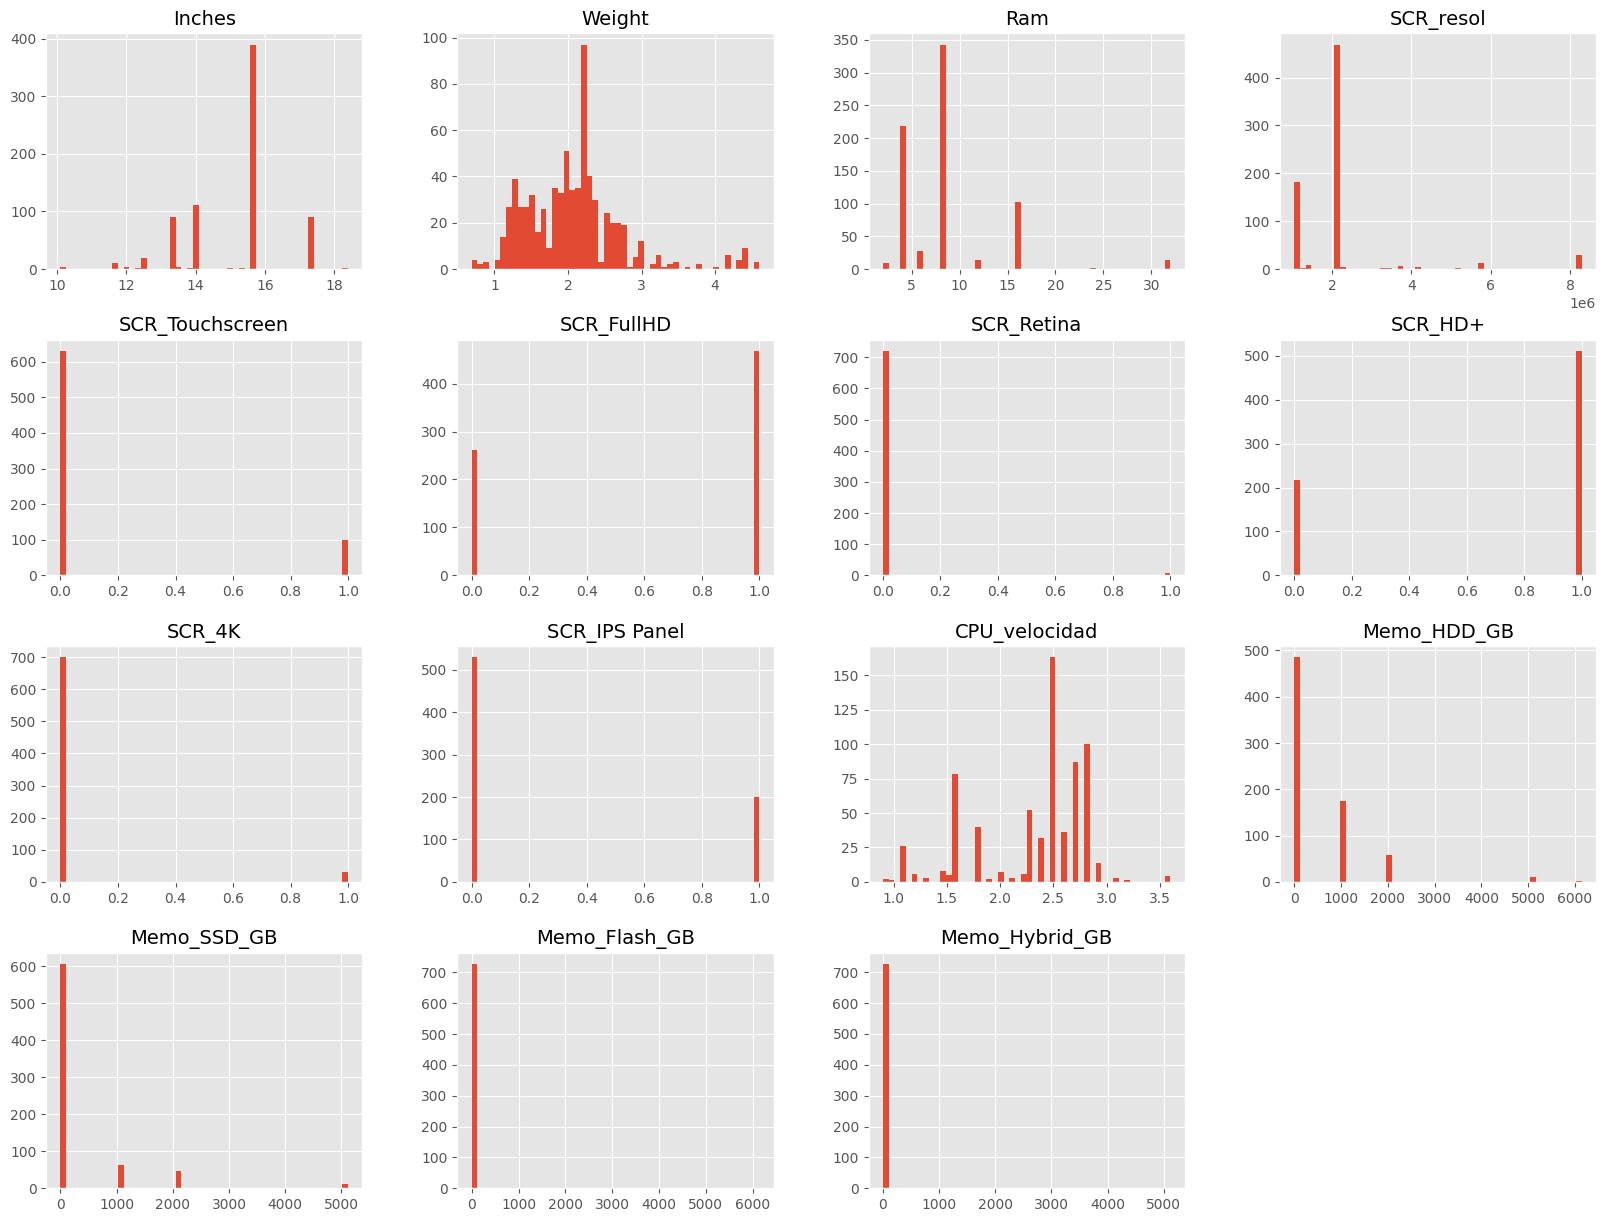

In [39]:
# Configurar las opciones de visualización
plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

# Histogramas de las variables numéricas
pcs_eda[var_num].hist(bins=50, figsize=(20, 15))
plt.show()

In [40]:
numeric_cols = pcs_eda.select_dtypes(include=np.number)

# Calcular el rango intercuartílico solo para las columnas numéricas
Q1 = numeric_cols.quantile(0.25)
Q3 = numeric_cols.quantile(0.75)
IQR = Q3 - Q1

# Definir un límite para considerar outliers solo para las columnas numéricas
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Eliminar outliers solo para las columnas numéricas
pcs_eda_no_outliers = pcs_eda[(numeric_cols >= lower_bound) & (numeric_cols <= upper_bound)].dropna()

In [41]:
var_fuera = []
cardinality = pcs_eda.select_dtypes(include='object').nunique()

# Definir un umbral para la cardinalidad (por ejemplo, 10)
umbral_cardinalidad = 15

# Identificar las columnas categóricas con una cardinalidad alta
columnas_alta_cardinalidad = cardinality[cardinality > umbral_cardinalidad].index.tolist()

# Mover las columnas con alta cardinalidad a var_fuera y eliminarlas del DataFrame principal
var_fuera.append(columnas_alta_cardinalidad)
pcs_eda.drop(columns=columnas_alta_cardinalidad, inplace=True)

In [42]:
columnas_categoricas = pcs_eda.select_dtypes(include='object').columns

# Aplicar get_dummies a las columnas categóricas seleccionadas
pcs_eda_encoded = pd.get_dummies(pcs_eda, columns=columnas_categoricas, drop_first=True)

In [43]:
var_fuera

[['ScreenResolution',
  'Cpu',
  'Memory',
  'Gpu',
  'CPU_serie',
  'GPU_modelo',
  'GPU_familia']]

In [44]:
var_categ

['OpSys',
 'TypeName',
 'Company',
 'CPU_marca',
 'CPU_modelo',
 'CPU_serie',
 'GPU_marca',
 'GPU_familia']

In [45]:
# Seleccionar solo las columnas numéricas que quedan en pcs_eda
columnas_numericas = pcs_eda.select_dtypes(include=['int', 'float']).columns

# Crear un objeto StandardScaler
scaler = StandardScaler()

# Escalar las columnas numéricas seleccionadas
pcs_eda[columnas_numericas] = scaler.fit_transform(pcs_eda[columnas_numericas])

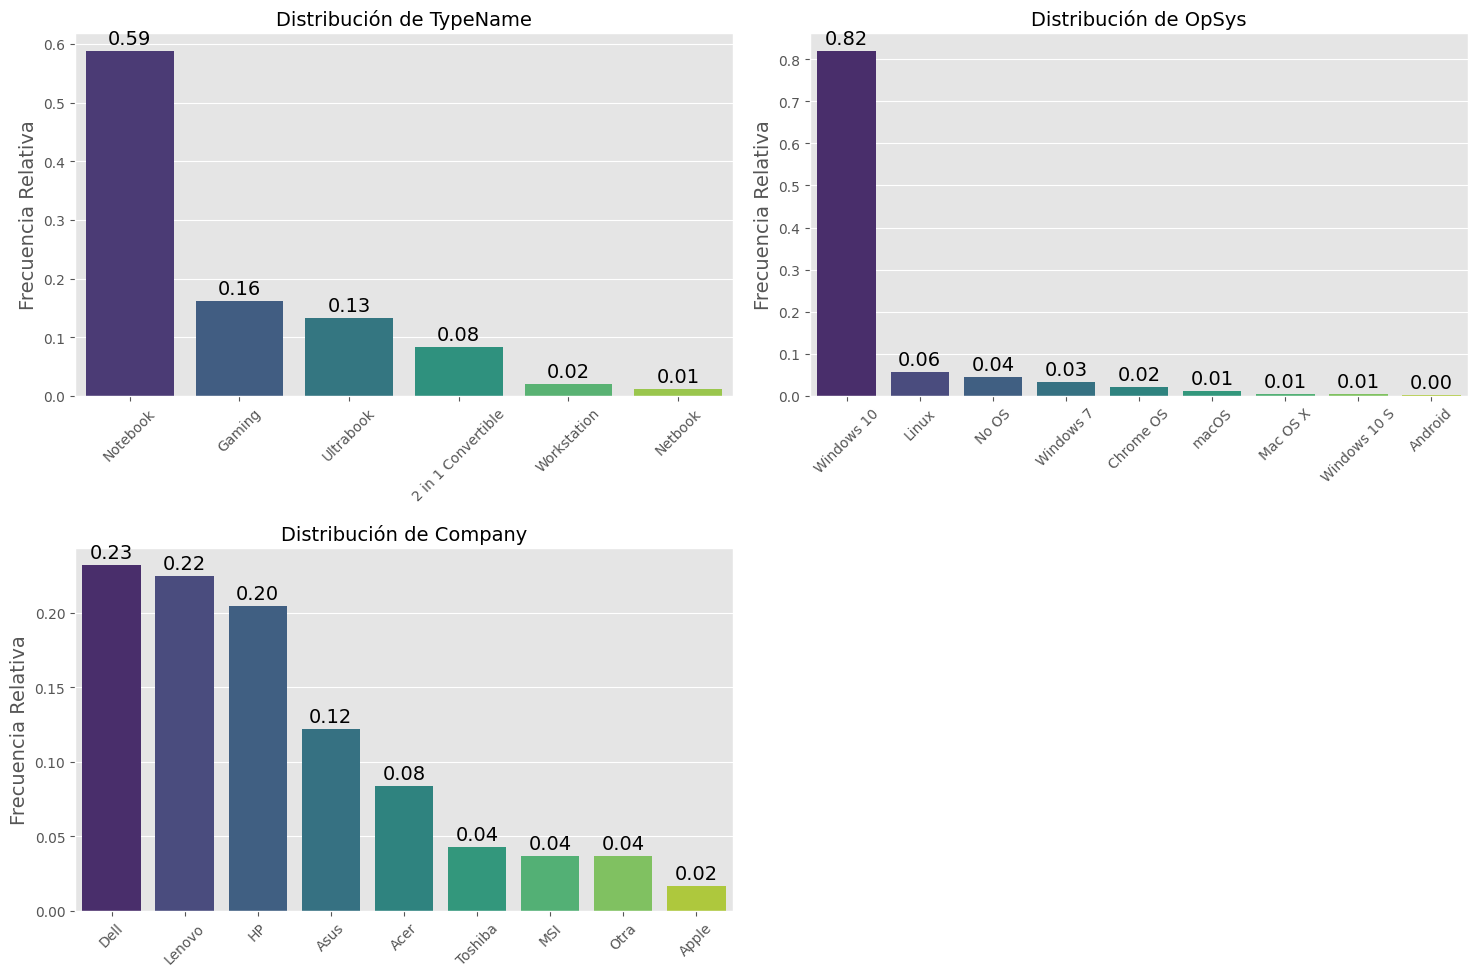

In [46]:
# A ver la frecuencia de las categóricas
bt.pinta_distribucion_categoricas(pcs_eda, ['TypeName',
 'OpSys',
 'Company'], relativa= True, mostrar_valores= True)

In [47]:
# Vamos ahora al análisis bivaruante, primero de las categóricas, una por una contra el target 

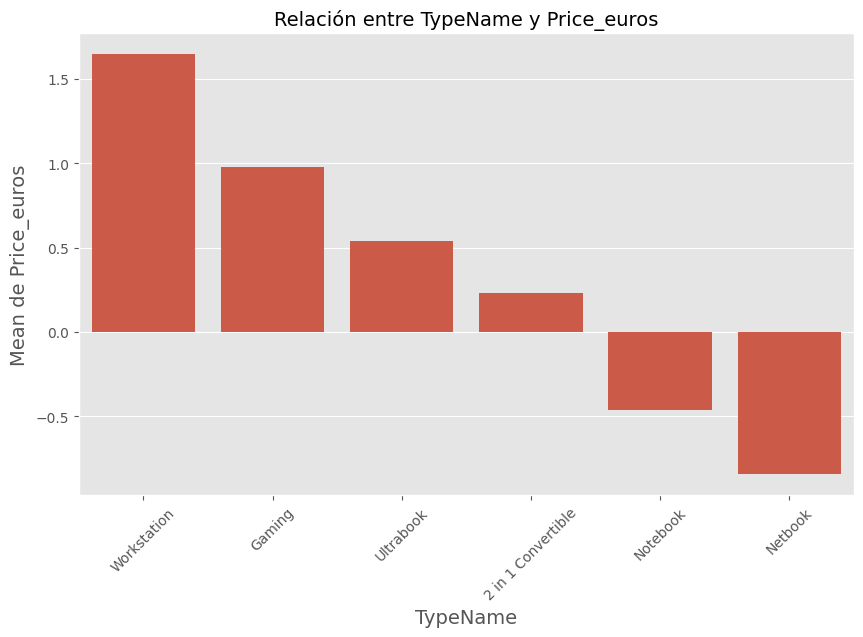

In [48]:
bt.plot_categorical_numerical_relationship(pcs_eda, categorical_col= "TypeName", numerical_col="Price_euros")
# a primera vista esta variable nos interesa
var_categ.append("TypeName")

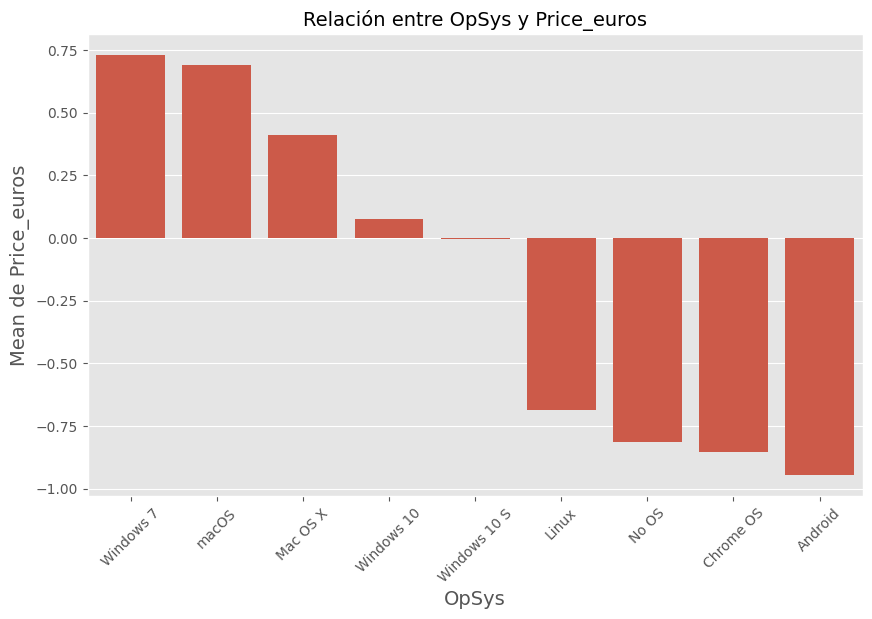

In [49]:
bt.plot_categorical_numerical_relationship(pcs_eda, categorical_col= "OpSys", numerical_col="Price_euros")
# a primera vista esta variable nos interesa
var_categ.append("OpSys")

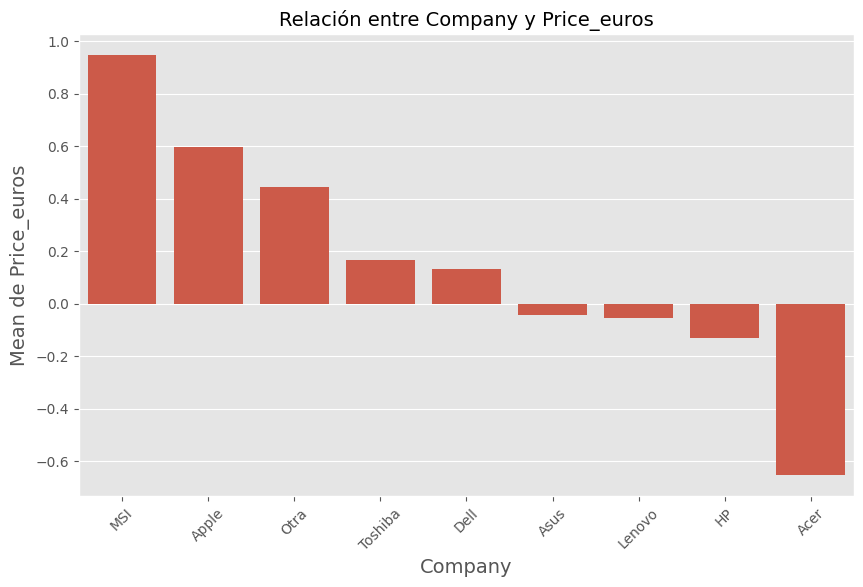

In [50]:
bt.plot_categorical_numerical_relationship(pcs_eda, categorical_col= "Company", numerical_col="Price_euros")
# a primera vista esta variable nos interesa, aunque es más plana que las otras. Al final me las he quedado todas
var_categ.append("Company")
# tal vez debería hilar más fino en Company a la hora de agrupar en Otras, para que no quede algo tan masivo?

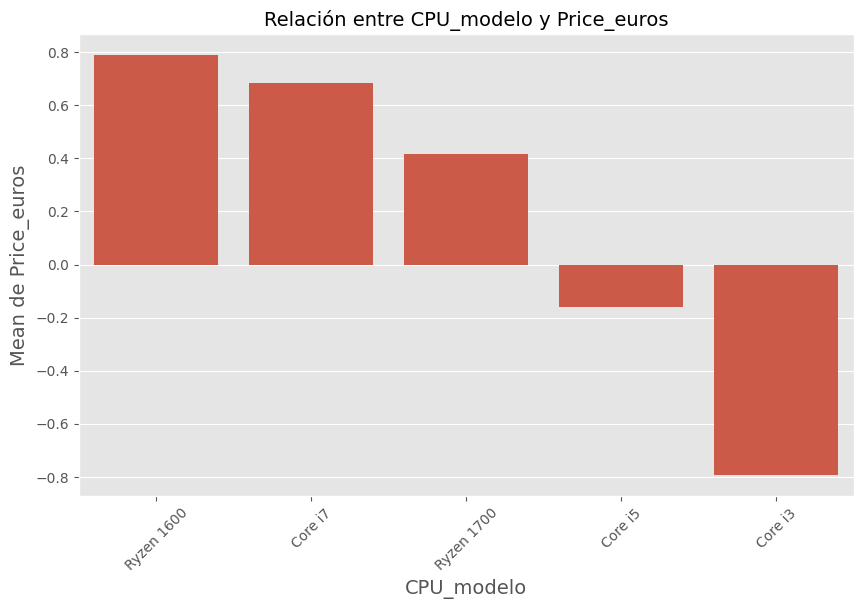

In [51]:
bt.plot_categorical_numerical_relationship(pcs_eda, categorical_col= "CPU_modelo", numerical_col="Price_euros")
# a primera vista esta variable nos interesa
var_categ.append("CPU_modelo")

In [52]:
# bt.plot_<ategorical_numerical_relationship(pcs_eda, categorical_col= "GPU_familia", numerical_col="Price_euros")
# a primera vista esta variable nos interesa
var_desc.append("GPU_familia")

# La familia así no la voy a hacer. Necesitaría reducir la cantidad de variables, ahora mismo no sé cómo agrupar habida cuenta la gran dispersión....

In [53]:
# bt.plot_categorical_numerical_relationship(pcs_eda, categorical_col= "CPU_serie", numerical_col="Price_euros")
# a primera vista esta variable tiene una gran dispersión, la descarto
var_desc.append("CPU_serie")

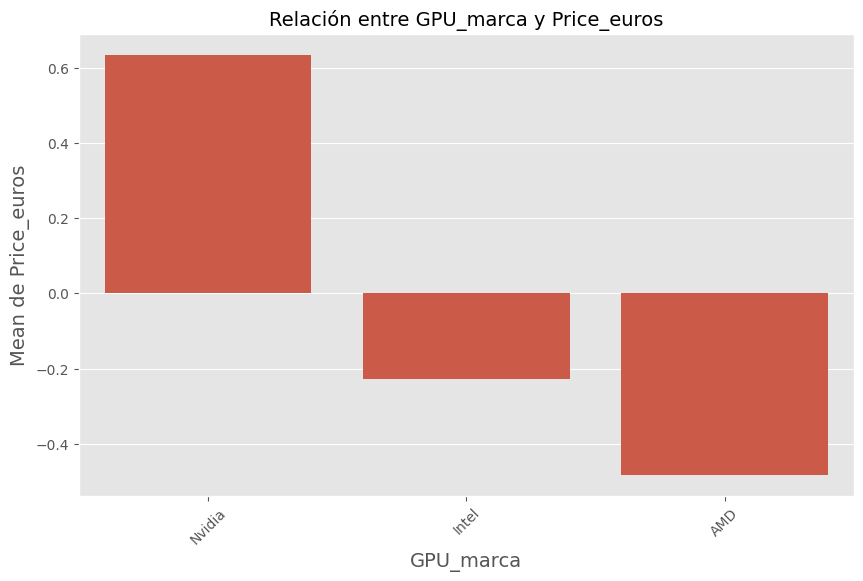

In [54]:
bt.plot_categorical_numerical_relationship(pcs_eda, categorical_col= "GPU_marca", numerical_col="Price_euros")
# a primera vista esta variable nos interesa
var_categ.append("GPU_marca")

In [55]:
# Analicemos ahora target vs las Numéricas
# queda pendiente... que lo haga solo

In [56]:
#Acá sería lo que me suele faltar del histograma??.... sí, en el análisis manual, sí, pero esta vez me lo salto

In [57]:
# Selección de features

In [58]:
pcs_eda.corr(numeric_only= True) 

,id,Inches,Ram,Weight,Price_euros,SCR_resol,SCR_Touchscreen,SCR_FullHD,SCR_Retina,SCR_HD+,SCR_4K,SCR_IPS Panel,CPU_velocidad,Memo_HDD_GB,Memo_SSD_GB,Memo_Flash_GB,Memo_Hybrid_GB
id,1.000000,0.038052,-0.021972,0.053836,-0.012153,-0.016118,-0.051275,0.021515,-0.023066,0.015846,-0.015949,0.004260,0.044151,0.030054,0.017816,-0.039252,-0.060369
Inches,0.038052,1.000000,0.265210,0.826690,0.106196,-0.048176,-0.337370,0.154676,-0.141750,0.126969,0.035327,-0.082234,0.297599,0.435477,0.358006,0.012729,0.077781
Ram,-0.021972,0.265210,1.000000,0.447989,0.754267,0.427906,0.132754,0.189848,0.030840,0.355508,0.329850,0.204620,0.370262,0.383043,0.544880,-0.003280,0.179068
Weight,0.053836,0.826690,0.447989,1.000000,0.287637,0.026300,-0.256300,0.140622,-0.120259,0.144575,0.100490,0.048787,0.329093,0.540878,0.548809,0.008493,0.184056
Price_euros,-0.012153,0.106196,0.754267,0.287637,1.000000,0.533679,0.192262,0.190767,0.095031,0.391916,0.406728,0.256700,0.432049,0.213434,0.433531,0.043679,0.131108
SCR_resol,-0.016118,-0.048176,0.427906,0.026300,0.533679,1.000000,0.383626,-0.096099,0.143615,0.365624,0.857162,0.234891,0.136817,0.080719,0.219383,-0.002851,-0.003475
SCR_Touchscreen,-0.051275,-0.337370,0.132754,-0.256300,0.192262,0.383626,1.000000,-0.096513,-0.044320,0.092749,0.280714,0.142147,-0.076922,-0.146170,-0.099940,-0.014436,-0.019107
SCR_FullHD,0.021515,0.154676,0.189848,0.140622,0.190767,-0.096099,-0.096513,1.000000,-0.149712,0.874622,-0.277412,0.202673,0.290346,0.076605,0.139423,0.027045,0.035995
SCR_Retina,-0.023066,-0.141750,0.030840,-0.120259,0.095031,0.143615,-0.044320,-0.149712,1.000000,-0.171174,-0.023162,0.181831,-0.027482,-0.062112,-0.040621,-0.003744,-0.005389
SCR_HD+,0.015846,0.126969,0.355508,0.144575,0.391916,0.365624,0.092749,0.874622,-0.171174,1.000000,0.135313,0.267310,0.325772,0.109078,0.223937,0.023479,0.031482


In [59]:
corr_matrix = pcs_eda.corr(numeric_only= True) 
corr_matrix["Price_euros"].sort_values(ascending = False)

# el id evidentemente no tiene ninguna influencia en el precio y RAM la tomo como categ.

Price_euros        1.000000
Ram                0.754267
SCR_resol          0.533679
Memo_SSD_GB        0.433531
CPU_velocidad      0.432049
SCR_4K             0.406728
SCR_HD+            0.391916
Weight             0.287637
SCR_IPS Panel      0.256700
Memo_HDD_GB        0.213434
SCR_Touchscreen    0.192262
SCR_FullHD         0.190767
Memo_Hybrid_GB     0.131108
Inches             0.106196
SCR_Retina         0.095031
Memo_Flash_GB      0.043679
id                -0.012153
Name: Price_euros, dtype: float64

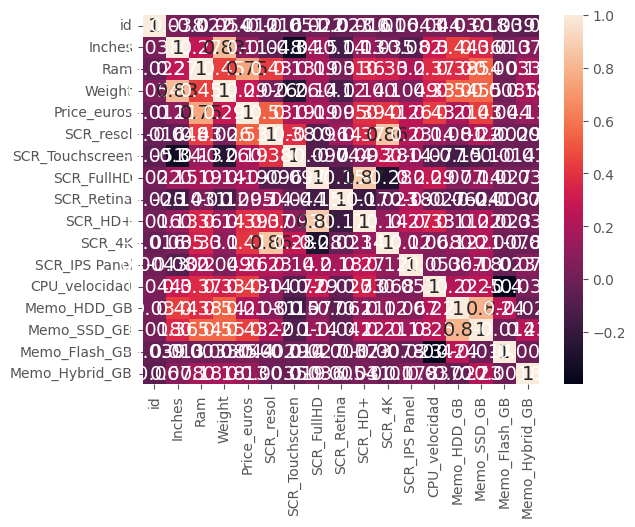

In [60]:
sns.heatmap(pcs_eda.corr(numeric_only = True),annot=True);
plt.show();

In [61]:
columnas = corr_matrix["Price_euros"][corr_matrix["Price_euros"] > 0.07].index.to_list() 
columnas

['Inches',
 'Ram',
 'Weight',
 'Price_euros',
 'SCR_resol',
 'SCR_Touchscreen',
 'SCR_FullHD',
 'SCR_Retina',
 'SCR_HD+',
 'SCR_4K',
 'SCR_IPS Panel',
 'CPU_velocidad',
 'Memo_HDD_GB',
 'Memo_SSD_GB',
 'Memo_Hybrid_GB']

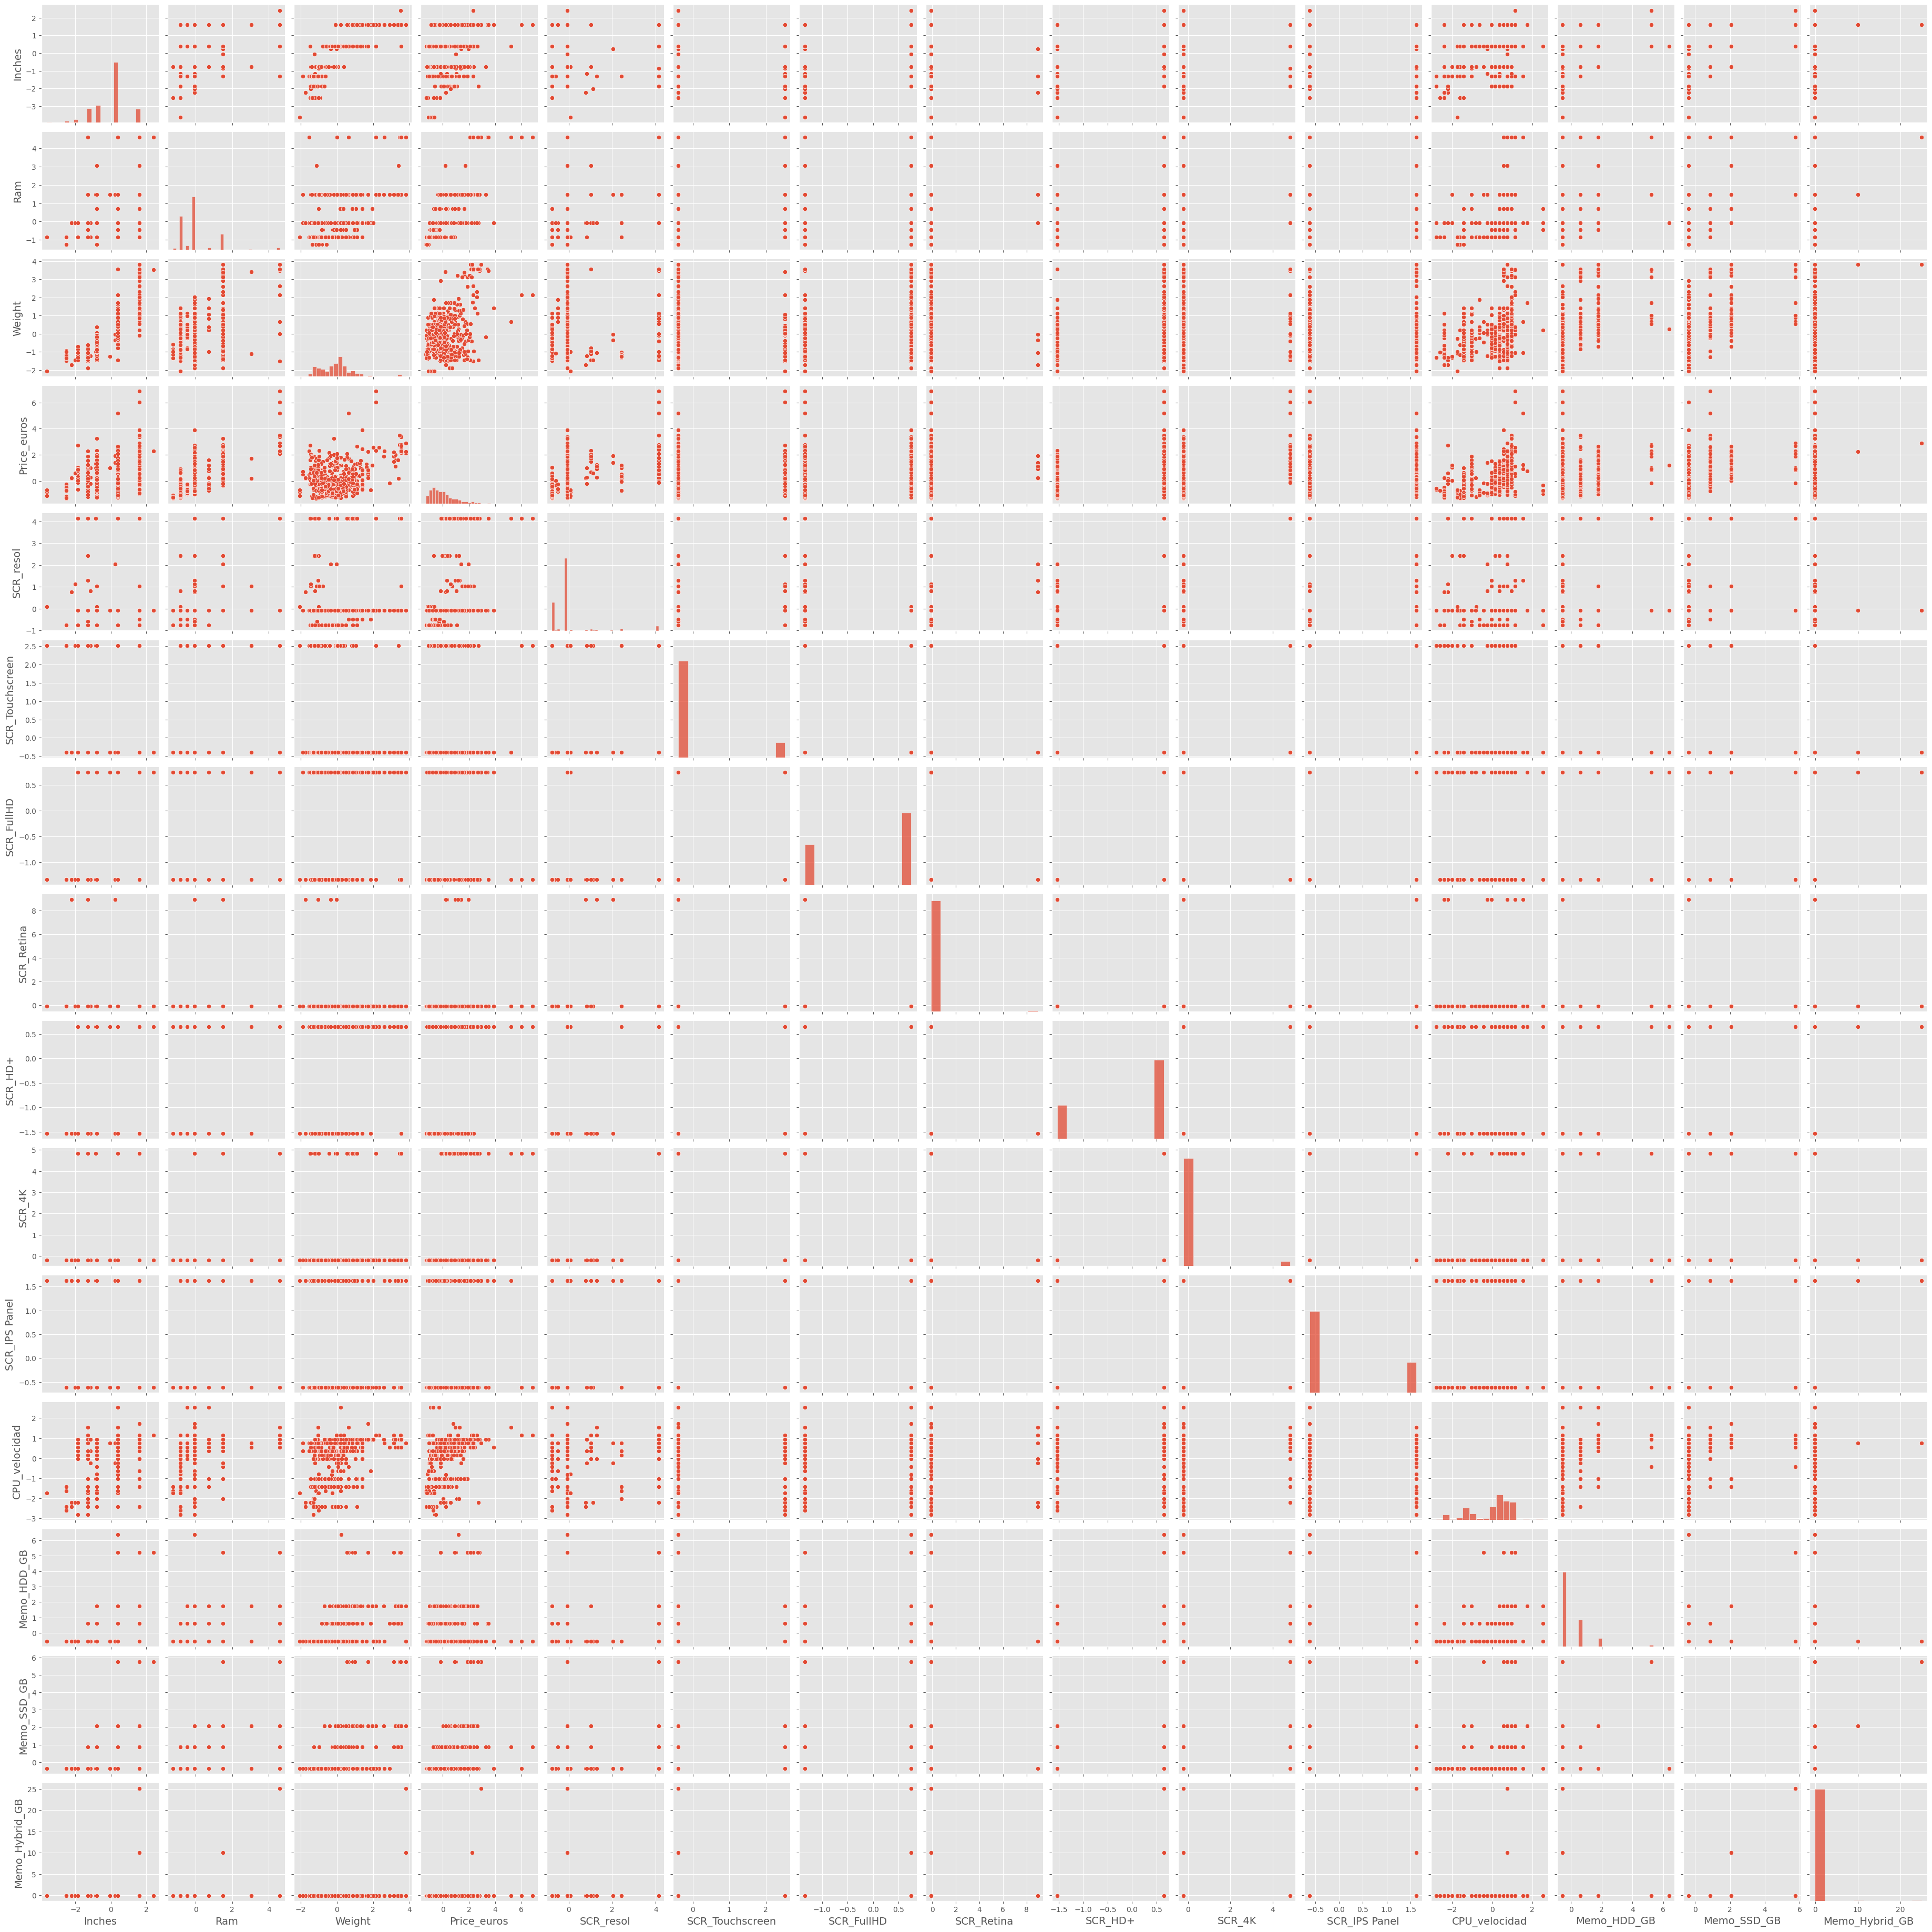

In [62]:
sns.pairplot(pcs_eda[columnas]);
# no tiene ningún entido...

In [63]:
# Elegir cuáles quedan, cuáles se descartan, cuáles son secundarios.... Fin del EDA
columnas_numericas = columnas
columnas_categoricas = var_categ

In [64]:
# seleccion FALTAAAAA.... bah, esta vez no la hago, la hará el propio modelo

In [65]:
X_train = pcs_eda.drop(columns=[target])
y_train = pcs_eda[target]

In [66]:
# Primero recojo en un pipeline todas las operaciones que fui probando con pcd_eda, e iré añadiendo las posteriores para ML
# Cambios pendientes de aplicar a test
#X_test.drop(columns=var_fuera, inplace=True)
#X_test[var_num] = scaler.transform(X_test[var_num])

In [ ]:
# Le tengo que aplicar los mismos cambios a X_test (y después aal df de prueba definitiva)

# Función para eliminar outliers
def remove_outliers(df, cols):
    # Tu código para eliminar outliers aquí
    return df

# Función para convertir una columna a tipo float
def convert_to_float(df, col):
    df[col] = df[col].astype(float)
    return df

# Función para agrupar marcas principales y renombrar el resto como "Otra" solo para la columna 'Company'
def group_top_brands_company(df, threshold=0.01):
    value_counts = df['Company'].value_counts(normalize=True)
    top_brands = value_counts[value_counts >= threshold].index.tolist()
    other_brands = [brand for brand in df['Company'].unique() if brand not in top_brands]
    df['Company'] = df['Company'].replace(other_brands, "Otra")
    return df

# Función para crear variables dummy para las variables categóricas
def create_dummies(df, cat_cols):
    # Tu código para crear variables dummy aquí
    return df

# Función para escalar las variables numéricas
def scale_numeric(df, num_cols):
    scaler = StandardScaler()
    df[num_cols] = scaler.fit_transform(df[num_cols])
    return df

# Función para aplicar todas las transformaciones
def preprocess_data(df, cat_cols, num_cols):
    df = remove_outliers(df, num_cols)
    df['Weight'] = df['Weight'].apply(lambda x: float(x.replace('kg', '').replace(',', '.')))  # Convertir 'Weight' a tipo float
    df['Ram'] = df['Ram'].apply(lambda x: int(x.replace('GB', '')))  # Convertir 'Ram' a tipo int
    df = convert_to_float(df, 'Inches')  # Convertir la columna 'Inches' a tipo float
    df = group_top_brands_company(df)  # Agrupar marcas principales y renombrar el resto como "Otra" solo para la columna 'Company'
    df = extract_screen_resolution(df)  # Aplicar transformación específica para 'ScreenResolution' antes de escalar
    df = create_dummies(df, cat_cols)
    df = scale_numeric(df, num_cols)
    return df

In [67]:
# Esto para próximos nuevos datos

# Drop inicial
pcs = pcs.drop("laptop_ID", axis = 1)
pcs = pcs.drop("Product", axis = 1)

# Y estas transformaciones:

# Company
marcas_ppales = pcs_eda['Company'].value_counts().sort_values(ascending=False) / pcs_eda['Company'].count()
top_10_companies = marcas_ppales[marcas_ppales >= 0.01].index.tolist()
otras_marcas = [company for company in pcs_eda['Company'].unique() if company not in top_10_companies]
pcs_eda['Company'] = pcs_eda['Company'].replace(otras_marcas, "Otra")

# Weight
pcs_eda['Weight'] = pcs_eda['Weight'].apply(lambda x: int(x.replace('kg', '').replace('.', '')))

# Ram
pcs_eda['Ram'] = pcs_eda['Ram'].apply(lambda x: int(x.replace('GB', '')))

# ScreenResolution

def extract_resolution(s):
    match = re.search(r'(\d{3,4})x(\d{3,4})', s)
    if match:
        return int(match.group(1)) * int(match.group(2))
    else:
        return None
    
pcs_eda['SCR_resol'] = pcs_eda['ScreenResolution'].apply(extract_resolution)
for label in ['Touchscreen', 'FullHD', 'Retina', 'HD+', '4K', 'IPS Panel']:
    pcs_eda[f'SCR_{label}'] = pcs_eda['ScreenResolution'].str.contains(label).astype(int)


# CPU
def extract_cpu_info(cpu):
    # Patrones para extraer la marca, la velocidad, el modelo y la serie
    brand_pattern = r'Intel|AMD'
    speed_pattern = r'(\d+\.\d+)GHz'
    model_pattern = r'\b(?:Core [iI]\d+|Ryzen \d+)\b'
    series_pattern = r'(?:Intel|AMD)(.*?)\b(?:Core [iI]\d+|Ryzen \d+|$)'
    
    # Extraer la marca
    brand = 0 if "Intel" in cpu else 1
    
    # Extraer la velocidad
    speed_match = re.search(speed_pattern, cpu)
    speed = float(speed_match.group(1)) if speed_match else None
    
    # Extraer el modelo
    model_match = re.search(model_pattern, cpu)
    model = model_match.group() if model_match else None
    
    # Extraer la serie
    series_match = re.search(series_pattern, cpu)
    series = series_match.group(1).strip() if series_match else None
    
    return brand, speed, model, series

# Aplicar la función extract_cpu_info a la columna "CPU"
pcs_eda['CPU_marca'], pcs_eda['CPU_velocidad'], pcs_eda['CPU_modelo'], pcs_eda['CPU_serie'] = zip(*pcs_eda['Cpu'].apply(extract_cpu_info))

# Verificar los cambios
print(pcs_eda.head())

# Memoria

def extract_memory_info(memory):
    # Patrón para extraer la cantidad de memoria y la unidad
    memory_pattern = r'(\d+)\s*(?:GB|T|TB)'
    
    # Patrón para detectar las palabras clave
    keyword_pattern = r'HDD|SSD|Flash Storage|Hybrid'
    
    # Buscar la cantidad de memoria y la unidad
    match = re.findall(memory_pattern, memory)
    if match:
        # Convertir TB a GB si es necesario
        memory_value = int(match[0][0]) * 1024 if 'T' in memory else int(match[0][0])
    else:
        memory_value = 0
    
    # Buscar las palabras clave
    keywords = re.findall(keyword_pattern, memory)
    
    # Crear un diccionario para almacenar los valores de almacenamiento correspondientes a cada categoría
    storage_dict = {'HDD': 0, 'SSD': 0, 'Flash Storage': 0, 'Hybrid': 0}
    for keyword in keywords:
        storage_dict[keyword] = memory_value
    
    return storage_dict['HDD'], storage_dict['SSD'], storage_dict['Flash Storage'], storage_dict['Hybrid']

# Aplicar la función extract_memory_info a la columna "Memory"
pcs_eda['Memo_HDD'], pcs_eda['Memo_SSD'], pcs_eda['Memo_Flash'], pcs_eda['Memo_Hybrid'] = zip(*pcs_eda['Memory'].apply(extract_memory_info))

# Renombrar las columnas restantes
pcs_eda.rename(columns={'Memo_HDD': 'Memo_HDD_GB', 'Memo_SSD': 'Memo_SSD_GB', 'Memo_Flash': 'Memo_Flash_GB', 'Memo_Hybrid': 'Memo_Hybrid_GB'}, inplace=True)

# GPU
def extract_gpu_info(gpu):
    # Dividir el nombre del GPU en palabras
    gpu_parts = gpu.split()
    
    # Marca del GPU (primera palabra del string)
    gpu_brand = gpu_parts[0]
    
    # Modelo del GPU (buscar números seguidos de letras al final del string)
    gpu_model = None
    for part in gpu_parts:
        if any(char.isdigit() for char in part):
            gpu_model = ''.join(filter(str.isdigit, part))
            break
    
    # Familia del GPU (todo lo que queda después de la marca y el modelo)
    gpu_family = ' '.join(gpu_parts[1:]) if gpu_model else ' '.join(gpu_parts[1:])
    
    return gpu_brand, gpu_model, gpu_family

# Aplicar la función extract_gpu_info a la columna "Gpu"
pcs_eda['GPU_marca'], pcs_eda['GPU_modelo'], pcs_eda['GPU_familia'] = zip(*pcs_eda['Gpu'].apply(extract_gpu_info))

KeyError: "['laptop_ID'] not found in axis"

In [ ]:
# y LO SIGUIENTE QUE HABRÁ QUE INCORPORARLO A ESTE PIPELINE PARA LOS DATOS NUEVOS??

In [ ]:
# A lo que haya que aplicarle el standardscaler (y no hay ninguna para log)

In [ ]:
std_scaler = StandardScaler()
resultado_standardization = pd.DataFrame(std_scaler.fit_transform(X_train[var_num]),columns = var_num)
resultado_standardization.head()

,Weight,Ram,SCR_resol,CPU_velocidad,Memo_HDD_GB,Memo_SSD_GB,Memo_Flash_GB,Memo_Hybrid_GB,GPU_modelo,Inches
0,-0.861775,-0.849979,-0.072099,NaN,0.600361,-0.365985,-0.037884,-0.048199,-0.040244,0.378771
1,-0.717834,-0.849979,-0.765388,NaN,-0.555546,-0.363593,-0.037884,-0.048199,-0.057333,0.378771
2,1.130671,-0.849979,-0.765388,-1.418953,0.600361,-0.365985,-0.037884,-0.048199,-0.046218,0.378771
3,-0.710259,-0.070564,-0.072099,-1.418953,0.600361,-0.365985,-0.037884,-0.048199,-0.043022,0.378771
4,0.592786,-0.070564,-0.765388,-1.418953,1.756267,-0.365985,-0.037884,-0.048199,-0.046218,-0.783550


(2,)


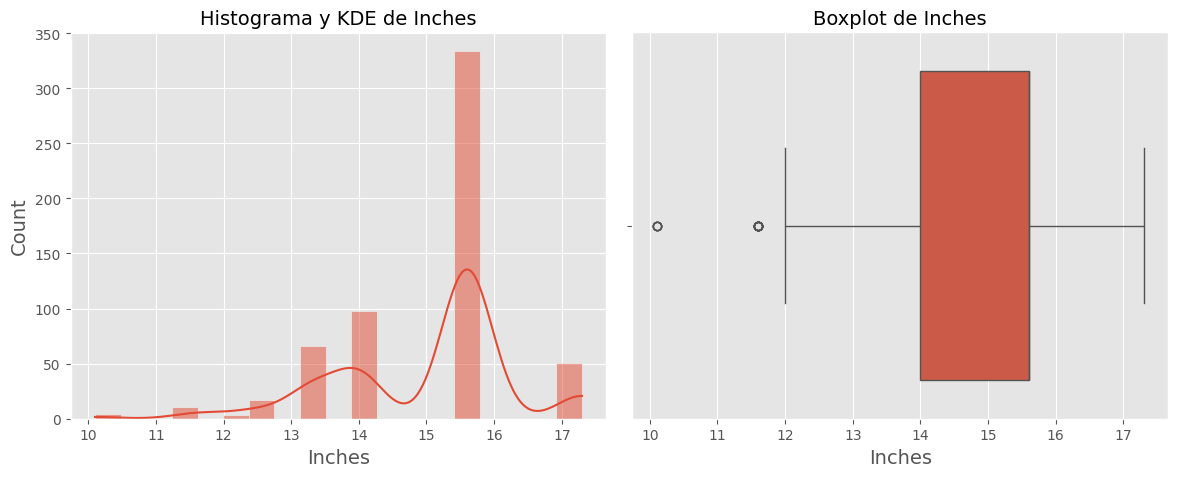

In [ ]:
# Y a ver si hay outliers, y los quito

bt.plot_combined_graphs(X_train, ["Inches"])

In [ ]:
Q1 = X_train['Inches'].quantile(0.25)
Q3 = X_train['Inches'].quantile(0.75)

# Calcula el rango intercuartil
IQR = Q3 - Q1

# Define los límites para los outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filtra los outliers
outliers = X_train[(X_train['Inches'] < lower_bound) | (X_train['Inches'] > upper_bound)]

# Elimina los outliers del conjunto de datos X_train
X_train = X_train[(X_train['Inches'] >= lower_bound) & (X_train['Inches'] <= upper_bound)]

(2,)


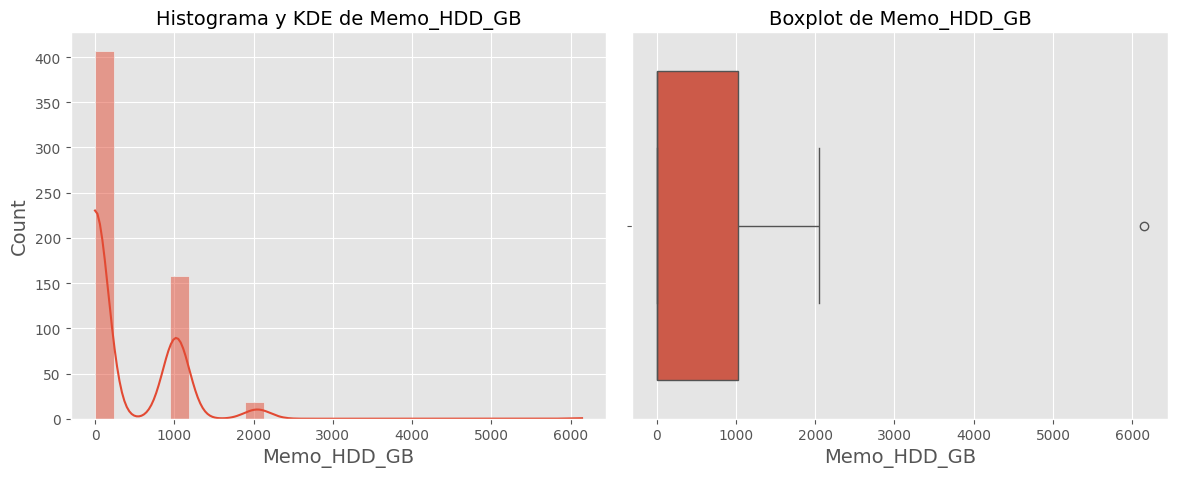

In [ ]:
# Y a ver si hay outliers
bt.plot_combined_graphs(X_train, ["Memo_HDD_GB"])

In [ ]:
Q1 = X_train['Memo_HDD_GB'].quantile(0.25)
Q3 = X_train['Memo_HDD_GB'].quantile(0.75)

# Calcula el rango intercuartil
IQR = Q3 - Q1

# Define los límites para los outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filtra los outliers
outliers = X_train[(X_train['Memo_HDD_GB'] < lower_bound) | (X_train['Memo_HDD_GB'] > upper_bound)]

# Elimina los outliers del conjunto de datos X_train
X_train = X_train[(X_train['Memo_HDD_GB'] >= lower_bound) & (X_train['Memo_HDD_GB'] <= upper_bound)]

(2,)


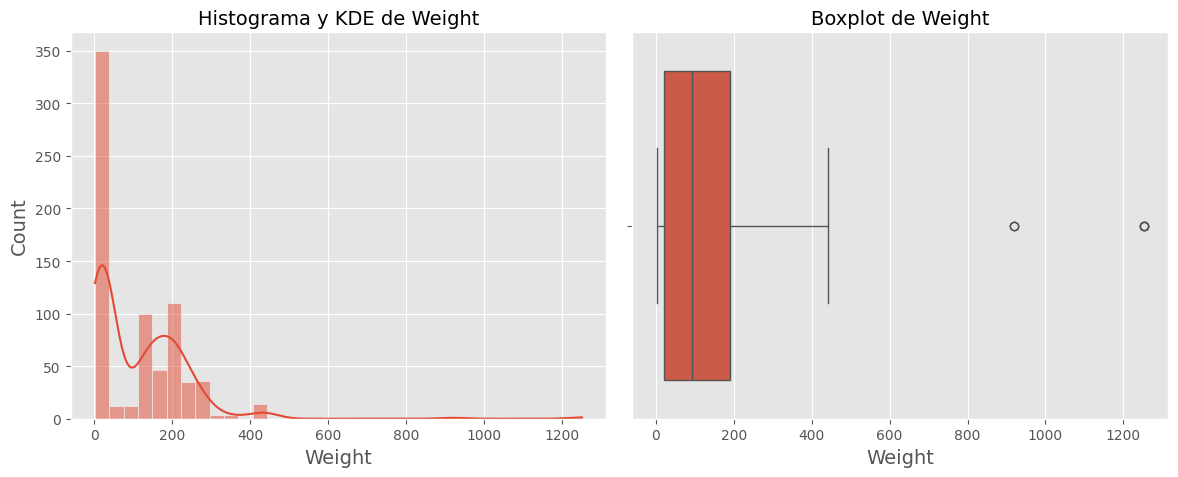

In [ ]:
# Y a ver si hay outliers
bt.plot_combined_graphs(X_train, ["Weight"])

In [ ]:
Q1 = X_train['Weight'].quantile(0.25)
Q3 = X_train['Weight'].quantile(0.75)

# Calcula el rango intercuartil
IQR = Q3 - Q1

# Define los límites para los outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filtra los outliers
outliers = X_train[(X_train['Weight'] < lower_bound) | (X_train['Weight'] > upper_bound)]

# Elimina los outliers del conjunto de datos X_train
X_train = X_train[(X_train['Weight'] >= lower_bound) & (X_train['Weight'] <= upper_bound)]

(2,)


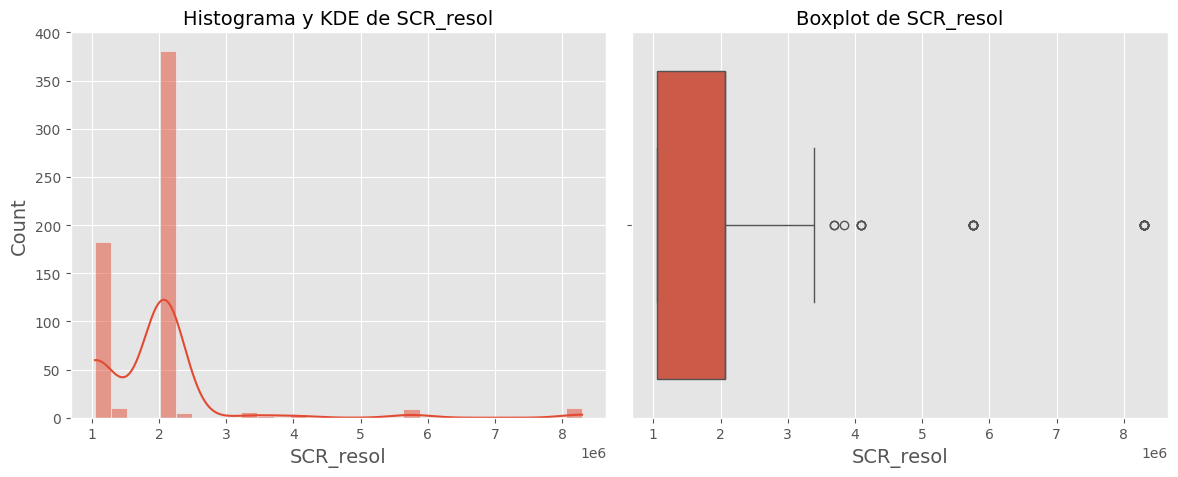

In [ ]:
bt.plot_combined_graphs(X_train, ["SCR_resol"])

In [ ]:
Q1 = X_train['Ram'].quantile(0.25)
Q3 = X_train['Ram'].quantile(0.75)

# Calcula el rango intercuartil
IQR = Q3 - Q1

# Define los límites para los outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filtra los outliers
outliers = X_train[(X_train['Ram'] < lower_bound) | (X_train['Ram'] > upper_bound)]

# Elimina los outliers del conjunto de datos X_train
X_train = X_train[(X_train['Ram'] >= lower_bound) & (X_train['Ram'] <= upper_bound)]

In [ ]:
Q1 = X_train['SCR_resol'].quantile(0.25)
Q3 = X_train['SCR_resol'].quantile(0.75)

# Calcula el rango intercuartil
IQR = Q3 - Q1

# Define los límites para los outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filtra los outliers
outliers = X_train[(X_train['SCR_resol'] < lower_bound) | (X_train['SCR_resol'] > upper_bound)]

# Elimina los outliers del conjunto de datos X_train
X_train = X_train[(X_train['SCR_resol'] >= lower_bound) & (X_train['SCR_resol'] <= upper_bound)]

In [ ]:
# Tratamiento de las categóricas (no ordinales)

In [ ]:
X_train = pcs_eda.drop("Price_euros", axis = 1)

In [ ]:
X_train = pd.get_dummies(X_train, columns=['Company'], prefix='Marca', prefix_sep='_', drop_first=True)

In [ ]:
X_train = pd.get_dummies(X_train, columns=['CPU_marca'], prefix='Marca_CPU', prefix_sep='_', drop_first=True) # edit

In [ ]:
X_train = pd.get_dummies(X_train, columns=['GPU_marca'], prefix='Marca_GPU', prefix_sep='_', drop_first=True) # edit

In [ ]:
X_train = pd.get_dummies(X_train, columns=['TypeName'], prefix='Tipo', prefix_sep='_', drop_first=True) # edit

In [ ]:
X_train = pd.get_dummies(X_train, columns=['OpSys'], prefix='S.O.', prefix_sep='_', drop_first=True) # edit

In [ ]:
# Hay que añadir todas estas operaciones que ya hemos hecho a nuestro test

In [ ]:
~# después tal vez habrá que hacer reducción de la dimencionalidad con PCA O se puede probar primero sin esta reducción, solo dejarla para si sobra tiempo

In [ ]:
# Modelo

In [ ]:
lin_reg = LinearRegression()
tree_reg = DecisionTreeRegressor(random_state = 42)

In [ ]:
lin_reg.fit(X,y)
tree_reg.fit(X,y)

ValueError: could not convert string to float: 'Dell'

In [ ]:
train_pred_lin = lin_reg.predict(X)
train_pred_tree = tree_reg.predict(X)

In [ ]:
train_pred_lin

In [ ]:
# Otro:
lm = LinearRegression()
lm.fit(X_train, y_train)

# Y ahora vemos los pesos
lm.fit(X_train, y_train)

lm.coef_

coef_df = pd.DataFrame(lm.coef_, X.columns, 
                      columns=['Coefficient'])
coef_df

ValueError: could not convert string to float: 'Full HD 1920x1080'

In [ ]:
# Esto para próximos nuevos datos

# Drop inicial
pcs = pcs.drop("laptop_ID", axis = 1)
pcs = pcs.drop("Product", axis = 1)

# Y estas transformaciones:

# Company
marcas_ppales = pcs_eda['Company'].value_counts().sort_values(ascending=False) / pcs_eda['Company'].count()
top_10_companies = marcas_ppales[marcas_ppales >= 0.01].index.tolist()
otras_marcas = [company for company in pcs_eda['Company'].unique() if company not in top_10_companies]
pcs_eda['Company'] = pcs_eda['Company'].replace(otras_marcas, "Otra")

# Weight
pcs_eda['Weight'] = pcs_eda['Weight'].apply(lambda x: int(x.replace('kg', '').replace('.', '')))

# Ram
pcs_eda['Ram'] = pcs_eda['Ram'].apply(lambda x: int(x.replace('GB', '')))

# ScreenResolution

def extract_resolution(s):
    match = re.search(r'(\d{3,4})x(\d{3,4})', s)
    if match:
        return int(match.group(1)) * int(match.group(2))
    else:
        return None
    
pcs_eda['SCR_resol'] = pcs_eda['ScreenResolution'].apply(extract_resolution)
for label in ['Touchscreen', 'FullHD', 'Retina', 'HD+', '4K', 'IPS Panel']:
    pcs_eda[f'SCR_{label}'] = pcs_eda['ScreenResolution'].str.contains(label).astype(int)


# CPU
def extract_cpu_info(cpu):
    # Patrones para extraer la marca, la velocidad, el modelo y la serie
    brand_pattern = r'Intel|AMD'
    speed_pattern = r'(\d+\.\d+)GHz'
    model_pattern = r'\b(?:Core [iI]\d+|Ryzen \d+)\b'
    series_pattern = r'(?:Intel|AMD)(.*?)\b(?:Core [iI]\d+|Ryzen \d+|$)'
    
    # Extraer la marca
    brand = 0 if "Intel" in cpu else 1
    
    # Extraer la velocidad
    speed_match = re.search(speed_pattern, cpu)
    speed = float(speed_match.group(1)) if speed_match else None
    
    # Extraer el modelo
    model_match = re.search(model_pattern, cpu)
    model = model_match.group() if model_match else None
    
    # Extraer la serie
    series_match = re.search(series_pattern, cpu)
    series = series_match.group(1).strip() if series_match else None
    
    return brand, speed, model, series

# Aplicar la función extract_cpu_info a la columna "CPU"
pcs_eda['CPU_marca'], pcs_eda['CPU_velocidad'], pcs_eda['CPU_modelo'], pcs_eda['CPU_serie'] = zip(*pcs_eda['Cpu'].apply(extract_cpu_info))

# Verificar los cambios
print(pcs_eda.head())

# Memoria

def extract_memory_info(memory):
    # Patrón para extraer la cantidad de memoria y la unidad
    memory_pattern = r'(\d+)\s*(?:GB|T|TB)'
    
    # Patrón para detectar las palabras clave
    keyword_pattern = r'HDD|SSD|Flash Storage|Hybrid'
    
    # Buscar la cantidad de memoria y la unidad
    match = re.findall(memory_pattern, memory)
    if match:
        # Convertir TB a GB si es necesario
        memory_value = int(match[0][0]) * 1024 if 'T' in memory else int(match[0][0])
    else:
        memory_value = 0
    
    # Buscar las palabras clave
    keywords = re.findall(keyword_pattern, memory)
    
    # Crear un diccionario para almacenar los valores de almacenamiento correspondientes a cada categoría
    storage_dict = {'HDD': 0, 'SSD': 0, 'Flash Storage': 0, 'Hybrid': 0}
    for keyword in keywords:
        storage_dict[keyword] = memory_value
    
    return storage_dict['HDD'], storage_dict['SSD'], storage_dict['Flash Storage'], storage_dict['Hybrid']

# Aplicar la función extract_memory_info a la columna "Memory"
pcs_eda['Memo_HDD'], pcs_eda['Memo_SSD'], pcs_eda['Memo_Flash'], pcs_eda['Memo_Hybrid'] = zip(*pcs_eda['Memory'].apply(extract_memory_info))

# Renombrar las columnas restantes
pcs_eda.rename(columns={'Memo_HDD': 'Memo_HDD_GB', 'Memo_SSD': 'Memo_SSD_GB', 'Memo_Flash': 'Memo_Flash_GB', 'Memo_Hybrid': 'Memo_Hybrid_GB'}, inplace=True)

# GPU
def extract_gpu_info(gpu):
    # Dividir el nombre del GPU en palabras
    gpu_parts = gpu.split()
    
    # Marca del GPU (primera palabra del string)
    gpu_brand = gpu_parts[0]
    
    # Modelo del GPU (buscar números seguidos de letras al final del string)
    gpu_model = None
    for part in gpu_parts:
        if any(char.isdigit() for char in part):
            gpu_model = ''.join(filter(str.isdigit, part))
            break
    
    # Familia del GPU (todo lo que queda después de la marca y el modelo)
    gpu_family = ' '.join(gpu_parts[1:]) if gpu_model else ' '.join(gpu_parts[1:])
    
    return gpu_brand, gpu_model, gpu_family

# Aplicar la función extract_gpu_info a la columna "Gpu"
pcs_eda['GPU_marca'], pcs_eda['GPU_modelo'], pcs_eda['GPU_familia'] = zip(*pcs_eda['Gpu'].apply(extract_gpu_info))




KeyError: "['laptop_ID'] not found in axis"

In [ ]:
# Después viene la evaluación contra test, y para ello la aplicación al test de todas las transformaciones que le hicimos a train (ver  más arriba)

In [ ]:
predictions = lm.predict(X_test)
predictions

sns.scatterplot(x=predictions,y=y_test); 
# comparamos predicciones y el y tets
plt.plot([0,2.5e6],[0,2.5e6],'red')
plt.show()

In [ ]:
# train error
pred_train = lm.predict(X_train)
print('MAE train', metrics.mean_absolute_error(y_train, pred_train))
print('MSE train', metrics.mean_squared_error(y_train, pred_train))
print('RMSE train', np.sqrt(metrics.mean_squared_error(y_train, pred_train)))
print('R2 train', lm.score(X_train,y_train))

In [ ]:
# test error
print('MAE test', metrics.mean_absolute_error(y_test, predictions))
print('MSE test', metrics.mean_squared_error(y_test, predictions))
print('RMSE test', np.sqrt(metrics.mean_squared_error(y_test, predictions)))
print('R2 test', lm.score(X_test,y_test))

In [ ]:
lm_scaled = LinearRegression()
lm_scaled.fit(X_train_scaled, y_train)

feat_coef = pd.DataFrame(lm_scaled.coef_,
                        X_train.columns, 
                        columns=['importance_standarized']).sort_values('importance_standarized',
                                                                       ascending=False)
feat_coef

In [ ]:
features = feat_coef.sort_values('importance_standarized')
plt.barh(features.index,features.importance_standarized)
plt.show()

In [ ]:
X_train.drop(columns='Avg. Area Number of Bedrooms',inplace=True)
X_test.drop(columns='Avg. Area Number of Bedrooms',inplace=True)
# quitamos esa variable

lm2 = LinearRegression() # creamos el modelo de RL
lm2.fit(X_train,y_train) # Hacemos el fit

pred2 = lm2.predict(X_test) # Hacemos el predict

print('MAE test', metrics.mean_absolute_error(y_test, pred2))
print('MSE test', metrics.mean_squared_error(y_test, pred2))
print('RMSE test', np.sqrt(metrics.mean_squared_error(y_test, pred2)))
print('R2 test', lm2.score(X_test,y_test))

In [ ]:
lr = linear_model.LinearRegression()
# instanciamos el regresor lineal

lr.fit(X_train, y_train)
# lo entrenamos con el fit a train

y_pred = lr.predict(X_test) # predecimos para X test
#baseline_error = metrics.mean_squared_error(y_test, y_pred)

# Y medimos los 2 errores: el de train, prediciendo para train y comparando
# con y train, y el error de test, haciendo la prediccion para x test, y
# comparando con y test
print("Train MSE:", metrics.mean_squared_error(y_train, lr.predict(X_train)))
print("Test MSE:", metrics.mean_squared_error(y_test, lr.predict(X_test)))

NameError: name 'linear_model' is not defined

In [ ]:
tree_reg = DecisionTreeRegressor(max_depth=2, random_state=42) # De nuevo sólo un hiperparámetro, para controlar la profundidad o número de niveles del árbol
tree_reg.fit(X, y)

y_pred = tree_reg.predict(X)

print("MAE:", mean_absolute_error(y, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y, y_pred)))

In [ ]:
tree_reg_bis = DecisionTreeRegressor(max_depth=3, random_state=42) # De nuevo sólo un hiperparámetro, para controlar la profundidad o número de niveles del árbol
tree_reg_bis.fit(X, y)

In [ ]:
y_pred = tree_reg_bis.predict(X)

print("MAE:", mean_absolute_error(y, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y, y_pred)))

In [ ]:
level_2 = np.sqrt(-cross_val_score(tree_reg, X, y, cv = 5, scoring= "neg_mean_squared_error"))
level_3 = np.sqrt(-cross_val_score(tree_reg_bis, X, y, cv = 5, scoring = "neg_mean_squared_error"))

print("Arbol 2 niveles:", level_2.mean())
print("Arbol 3 niveles:", level_3.mean())

In [ ]:
# Optimización hiperparámetros

In [ ]:
param_grid = {
    'alpha': [1e-10, 1e-4, 1e-2, 1, 5, 10, 20, 40],
    'l1_ratio': np.arange(0, 1, 0.01)
}

elastic = ElasticNet()

grid_search = GridSearchCV(elastic,
                           param_grid,
                           cv=5,
                           scoring='r2',
                           n_jobs=-1
                          )

grid_search.fit(X_train, y_train)

In [ ]:
grid_search.best_params_

In [ ]:
grid_search.best_score_

In [ ]:
grid_search.best_estimator_.score(X_test, y_test)

In [ ]:
rnd_reg = RandomForestRegressor(n_estimators=500,
                               max_depth=5,
                               random_state=42)
rnd_reg.fit(X_train_reg, 
           y_train_reg)

y_pred_reg = rnd_reg.predict(X_test_reg)
print("MAE:", mean_absolute_error(y_test_reg, y_pred_reg))
print("RMSE:", np.sqrt(mean_squared_error(y_test_reg, y_pred_reg)))

In [ ]:
xgb_reg = xgboost.XGBRFRegressor(random_state=42)
xgb_reg.fit(X_train_reg, y_train_reg)
y_pred = xgb_reg.predict(X_test_reg)
print("MAE:",mean_absolute_error(y_test_reg, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test_reg, y_pred)))

In [ ]:
lgbm_reg = LGBMRegressor(random_state=42)
lgbm_reg.fit(X_train_reg, y_train_reg)
y_pred = lgbm_reg.predict(X_test_reg)
print("MAE:",mean_absolute_error(y_test_reg, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test_reg, y_pred)))

In [ ]:
cb = CatBoostRegressor(n_estimators=200,
                      loss_function='RMSE',
                       learning_rate=0.4,
                       random_state=1,
                       verbose = False
                      )
pool_train = Pool(X_train2, y_train2,
                 cat_features=['cut','color','clarity'])

pool_test = Pool(X_test2, cat_features=['cut','color','clarity'])

cb.fit(pool_train)
y_pred = cb.predict(pool_test)

print('RMSE:', np.sqrt(mean_squared_error(y_test2,y_pred)))

In [ ]:
params_xgb = {'max_depth': [3, 6, 12],
          'learning_rate': [0.1, 0.2, 0.3, 0.4],
          'subsample': [0.3,0.6,1],
          'colsample_bytree': [0.5,1],
          'n_estimators': [100, 250, 500, 750],
          }

xgb = xgboost.XGBRegressor()

In [ ]:
ada_reg = AdaBoostRegressor(n_estimators=200,
                               random_state=42)
ada_reg.fit(X_train_reg, 
           y_train_reg)

y_pred_reg = ada_reg.predict(X_test_reg)
print("MAE:", mean_absolute_error(y_test_reg, y_pred_reg))
print("RMSE:", np.sqrt(mean_squared_error(y_test_reg, y_pred_reg)))

In [ ]:
param_grid = {
    "n_estimators": [100,400],
    "learning_rate": [0.1,1,3.2]
}

model_grid = GridSearchCV(ada_reg,
                          param_grid= param_grid,
                          cv = 5,
                          scoring = "neg_mean_squared_error") # Se intenta maximizar el scoring por eso cuando la métrica es mejor cuando es más baja hay que usar las negadas

model_grid.fit(X_train_reg,y_train_reg)

In [ ]:
model_grid.best_params_

In [ ]:
np.sqrt(-model_grid.best_score_)

In [ ]:
gbr = GradientBoostingRegressor() 

gbr.fit(X_train_reg, y_train_reg)
y_pred = gbr.predict(X_test_reg)

print("MAE:", mean_absolute_error(y_test_reg, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test_reg, y_pred)))

In [ ]:
xgb_reg = xgboost.XGBRFRegressor(random_state=42)
xgb_reg.fit(X_train_reg, y_train_reg)
y_pred = xgb_reg.predict(X_test_reg)
print("MAE:",mean_absolute_error(y_test_reg, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test_reg, y_pred)))

In [ ]:
lgbm_reg = LGBMRegressor(random_state=42)
lgbm_reg.fit(X_train_reg, y_train_reg)
y_pred = lgbm_reg.predict(X_test_reg)
print("MAE:",mean_absolute_error(y_test_reg, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test_reg, y_pred)))

In [ ]:
cb = CatBoostRegressor(n_estimators=200,
                      loss_function='RMSE',
                       learning_rate=0.4,
                       random_state=1,
                       verbose = False
                      )
pool_train = Pool(X_train2, y_train2,
                 cat_features=['cut','color','clarity'])

pool_test = Pool(X_test2, cat_features=['cut','color','clarity'])

cb.fit(pool_train)
y_pred = cb.predict(pool_test)

print('RMSE:', np.sqrt(mean_squared_error(y_test2,y_pred)))

In [ ]:
params_xgb = {'max_depth': [3, 6, 12],
          'learning_rate': [0.1, 0.2, 0.3, 0.4],
          'subsample': [0.3,0.6,1],
          'colsample_bytree': [0.5,1],
          'n_estimators': [100, 250, 500, 750],
          }

xgb = xgboost.XGBRegressor()

clf = RandomizedSearchCV(estimator=xgb,
                        cv=4,
                        n_iter=10,
                        param_distributions=params_xgb,
                        scoring='neg_mean_squared_error' 
                        )
clf.fit(X_train_reg, y_train_reg)

In [ ]:
clf.best_params_

In [ ]:
y_pred = clf.predict(X_test_reg)
print("MAE:",mean_absolute_error(y_test_reg, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test_reg, y_pred)))

In [ ]:
params_lgb = {'max_depth': [3, 6, 12],
          'learning_rate': [0.1, 0.2, 0.3, 0.4],
          'bagging_fraction': [0.3,0.6,1],
          'feature_fraction': [0.5,1],
          'n_estimators': [100, 250, 500, 750],
          'max_bins': [125,250]
          }

lgb = LGBMRegressor()

clf = RandomizedSearchCV(estimator=lgb,
                        cv=4,
                        n_iter=2,
                        param_distributions=params_lgb,
                        scoring='neg_mean_squared_error' 
                        )
clf.fit(X_train_reg, y_train_reg)

In [ ]:
clf.best_params_

In [ ]:
params_cat = {'depth': [3, 6, 12],
          'learning_rate': [0.1, 0.2, 0.3, 0.4],
          #'bagging_fraction': [0.3,0.6,1], No hay hiperparámetro equivalente
          'colsample_bylevel': [0.5,1],
          'iterations': [100, 250, 500, 750],
          "border_count": [125,250]
          }

cat_model = CatBoostRegressor(verbose = False)

clf = RandomizedSearchCV(estimator=cat_model,
                        cv=4,
                        n_iter=2,
                        param_distributions=params_cat,
                        scoring='neg_mean_squared_error' 
                        )
clf.fit(X_train_reg, y_train_regparams_cat = {'depth': [3, 6, 12],
          'learning_rate': [0.1, 0.2, 0.3, 0.4],
          #'bagging_fraction': [0.3,0.6,1], No hay hiperparámetro equivalente
          'colsample_bylevel': [0.5,1],
          'iterations': [100, 250, 500, 750],
          "border_count": [125,250]
          }

cat_model = CatBoostRegressor(verbose = False)

clf = RandomizedSearchCV(estimator=cat_model,
                        cv=4,
                        n_iter=2,
                        param_distributions=params_cat,
                        scoring='neg_mean_squared_error' 
                        )
clf.fit(X_train_reg, y_train_reg

In [ ]:
clf.best_params_

In [ ]:
# Comparación de todos los modelos

In [ ]:
model_names = ["Regresion Lineal","DecisionTree","Random Forest","XGBoost","LightGBM","CatBoost"]
lr_clf = LinearRegression()
tree_clf = DecisionTreeRegressor(random_state= 42)
rf_clf = RandomForestRegressor(random_state= 42)
xgb_clf = XGBRegressor(random_state = 42)
lgb_clf = LGBMRegressor(random_state= 42, verbose = -100)
cat_clf = CatBoostRegressor(random_state= 42, verbose = False)

model_set = [lr_clf, tree_clf, rf_clf, xgb_clf, lgb_clf, cat_clf]

In [ ]:
model_names = ["Regresion Lineal","DecisionTree","Random Forest","XGBoost","LightGBM","CatBoost"]
lr_clf = LinearRegression()
tree_clf = DecisionTreeRegressor(random_state= 42)
rf_clf = RandomForestRegressor(random_state= 42)
xgb_clf = XGBRegressor(random_state = 42)
lgb_clf = LGBMRegressor(random_state= 42, verbose = -100)
cat_clf = CatBoostRegressor(random_state= 42, verbose = False)

model_set = [lr_clf, tree_clf, rf_clf, xgb_clf, lgb_clf, cat_clf]

In [ ]:
for model_name, valores in metricas_cv.items():
    print(f"Model <{model_name}>, RMSE_CV: {np.sqrt(-np.mean(valores))}")
print(f"El ganador es {ganador}")

In [ ]:
# Optimzación del ganador

In [ ]:
params_grid = {
    "n_estimators": [100,200,400],
    "max_depth": [2,4,10],
    #"min_samples_leaf": [10,20,40],
    "max_features": ["sqrt","log2",None],
    "max_samples": [0.3,0.6,1]
}

rf_grid = GridSearchCV(rf_clf,
                       param_grid= params_grid,
                       cv = 5,
                       scoring = "neg_mean_squared_error",
                       n_jobs = -1)

rf_grid.fit(X_train, y_train)

In [ ]:
np.sqrt(-rf_grid.best_score_)

In [ ]:
rf_grid.best_params_

In [ ]:
y_pred = rf_grid.best_estimator_.predict(X_test)
print("MAE:", mean_absolute_error(y_test,y_pred))
print("MAPE:", mean_absolute_percentage_error(y_test,y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))

In [ ]:
metricas_optimizadas = {}

In [ ]:
### Linear Regresion
from sklearn.linear_model import ElasticNet

param_grid = {
    "alpha": [0.1, 1, 10, 100],
    "l1_ratio": [0.2,0.4,0.6,1]

} 
model = ElasticNet()
lr_grid = RandomizedSearchCV( model,
                             cv = 3, 
                             n_iter = 20,
                             param_distributions= param_grid,
                             scoring= "neg_mean_squared_error"
)

lr_grid.fit(X_train_scaled,y_train)
print("LR best_score:", np.sqrt(-lr_grid.best_score_))
metricas_optimizadas["Linear Regresion"] = np.sqrt(-lr_grid.best_score_)

In [ ]:
### DecisionTrees

tree_clf = DecisionTreeRegressor()

param_grid = {
    "max_depth": [1,2,4,8,None],
    "min_samples_leaf": [1,5,10,20],
    "max_features": ["sqrt","log2", None]
}

tree_grid = RandomizedSearchCV(tree_clf, 
                               cv = 3,
                               n_iter = 20,
                               param_distributions= param_grid, 
                               scoring = "neg_mean_squared_error")

tree_grid.fit(X_train,y_train)
print("Tree best_score:", np.sqrt(-tree_grid.best_score_))
metricas_optimizadas["Tree"] = np.sqrt(-tree_grid.best_score_)

In [ ]:
### RandomForest

rf_clf = RandomForestRegressor()

params_grid = {
    "n_estimators": [100,200,400],
    "max_depth": [2,4,10],
    "max_features": ["sqrt","log2",None],
    "max_samples": [0.3,0.6,1]
}

rf_grid = RandomizedSearchCV(rf_clf, 
                               cv = 3,
                               n_iter = 20,
                               param_distributions= param_grid, 
                               scoring = "neg_mean_squared_error")


rf_grid.fit(X_train, y_train)
print("RF best_score:", np.sqrt(-rf_grid.best_score_))
metricas_optimizadas["RandomForest"] = np.sqrt(-rf_grid.best_score_)

In [ ]:
### XGBoost

xgb_clf = XGBRegressor()

param_grid = {'max_depth': [3, 6, 10, 15],
          'learning_rate': [0.2, 0.6, 0.9],
          'subsample': np.arange(0.5, 1.0, 0.1),
          'colsample_bytree': np.arange(0.5, 1.0, 0.1),
          'colsample_bylevel': np.arange(0.5, 1.0, 0.1),
          'n_estimators': [100, 250, 500, 750],
          }

xgb_grid = RandomizedSearchCV(xgb_clf, 
                               cv = 3,
                               n_iter = 20,
                               param_distributions= param_grid, 
                               scoring = "neg_mean_squared_error")


xgb_grid.fit(X_train, y_train)
print("XGB best_score:", np.sqrt(-xgb_grid.best_score_))
metricas_optimizadas["XGBoost"] = np.sqrt(-xgb_grid.best_score_)

In [ ]:
### LightGBM 


lgb_clf = LGBMRegressor(verbose = -100)

param_grid= {'max_depth': [3, 6, 12],
          'learning_rate': [0.1, 0.2, 0.3, 0.4],
          'bagging_fraction': [0.3,0.6,1],
          'feature_fraction': [0.5,1],
          'n_estimators': [100, 250, 500, 750],
          'max_bins': [125,250]
          }

lgb_grid = RandomizedSearchCV(lgb_clf, 
                               cv = 3,
                               n_iter = 20,
                               param_distributions= param_grid, 
                               scoring = "neg_mean_squared_error")


lgb_grid.fit(X_train, y_train)
print("LGB best_score:", np.sqrt(-lgb_grid.best_score_))
metricas_optimizadas["LightGBM"] = np.sqrt(-lgb_grid.best_score_)

In [ ]:
### CatBoost

cat_clf = CatBoostRegressor(verbose = False)

param_grid= {'depth': [3, 6, 12],
          'learning_rate': [0.1, 0.2, 0.3, 0.4],
          #'bagging_fraction': [0.3,0.6,1], No hay hiperparámetro equivalente
          'colsample_bylevel': [0.5,1],
          'iterations': [100, 250, 500, 750],
          "border_count": [125,250]
          }


cat_grid = RandomizedSearchCV(cat_clf, 
                               cv = 3,
                               n_iter = 3,
                               param_distributions= param_grid, 
                               scoring = "neg_mean_squared_error")


cat_grid.fit(X_train, y_train)
print("CatBoost best_score:", np.sqrt(-cat_grid.best_score_))
metricas_optimizadas["CatBoost"] = np.sqrt(-cat_grid.best_score_)

In [ ]:
# Esto para próximos nuevos datos

# Drop inicial
pcs = pcs.drop("laptop_ID", axis = 1)
pcs = pcs.drop("Product", axis = 1)

# Y estas transformaciones:

# Company
marcas_ppales = pcs_eda['Company'].value_counts().sort_values(ascending=False) / pcs_eda['Company'].count()
top_10_companies = marcas_ppales[marcas_ppales >= 0.01].index.tolist()
otras_marcas = [company for company in pcs_eda['Company'].unique() if company not in top_10_companies]
pcs_eda['Company'] = pcs_eda['Company'].replace(otras_marcas, "Otra")

# Weight
pcs_eda['Weight'] = pcs_eda['Weight'].apply(lambda x: int(x.replace('kg', '').replace('.', '')))

# Ram
pcs_eda['Ram'] = pcs_eda['Ram'].apply(lambda x: int(x.replace('GB', '')))

# ScreenResolution

def extract_resolution(s):
    match = re.search(r'(\d{3,4})x(\d{3,4})', s)
    if match:
        return int(match.group(1)) * int(match.group(2))
    else:
        return None
    
pcs_eda['SCR_resol'] = pcs_eda['ScreenResolution'].apply(extract_resolution)
for label in ['Touchscreen', 'FullHD', 'Retina', 'HD+', '4K', 'IPS Panel']:
    pcs_eda[f'SCR_{label}'] = pcs_eda['ScreenResolution'].str.contains(label).astype(int)


# CPU
def extract_cpu_info(cpu):
    # Patrones para extraer la marca, la velocidad, el modelo y la serie
    brand_pattern = r'Intel|AMD'
    speed_pattern = r'(\d+\.\d+)GHz'
    model_pattern = r'\b(?:Core [iI]\d+|Ryzen \d+)\b'
    series_pattern = r'(?:Intel|AMD)(.*?)\b(?:Core [iI]\d+|Ryzen \d+|$)'
    
    # Extraer la marca
    brand = 0 if "Intel" in cpu else 1
    
    # Extraer la velocidad
    speed_match = re.search(speed_pattern, cpu)
    speed = float(speed_match.group(1)) if speed_match else None
    
    # Extraer el modelo
    model_match = re.search(model_pattern, cpu)
    model = model_match.group() if model_match else None
    
    # Extraer la serie
    series_match = re.search(series_pattern, cpu)
    series = series_match.group(1).strip() if series_match else None
    
    return brand, speed, model, series

# Aplicar la función extract_cpu_info a la columna "CPU"
pcs_eda['CPU_marca'], pcs_eda['CPU_velocidad'], pcs_eda['CPU_modelo'], pcs_eda['CPU_serie'] = zip(*pcs_eda['Cpu'].apply(extract_cpu_info))

# Verificar los cambios
print(pcs_eda.head())

# Memoria

def extract_memory_info(memory):
    # Patrón para extraer la cantidad de memoria y la unidad
    memory_pattern = r'(\d+)\s*(?:GB|T|TB)'
    
    # Patrón para detectar las palabras clave
    keyword_pattern = r'HDD|SSD|Flash Storage|Hybrid'
    
    # Buscar la cantidad de memoria y la unidad
    match = re.findall(memory_pattern, memory)
    if match:
        # Convertir TB a GB si es necesario
        memory_value = int(match[0][0]) * 1024 if 'T' in memory else int(match[0][0])
    else:
        memory_value = 0
    
    # Buscar las palabras clave
    keywords = re.findall(keyword_pattern, memory)
    
    # Crear un diccionario para almacenar los valores de almacenamiento correspondientes a cada categoría
    storage_dict = {'HDD': 0, 'SSD': 0, 'Flash Storage': 0, 'Hybrid': 0}
    for keyword in keywords:
        storage_dict[keyword] = memory_value
    
    return storage_dict['HDD'], storage_dict['SSD'], storage_dict['Flash Storage'], storage_dict['Hybrid']

# Aplicar la función extract_memory_info a la columna "Memory"
pcs_eda['Memo_HDD'], pcs_eda['Memo_SSD'], pcs_eda['Memo_Flash'], pcs_eda['Memo_Hybrid'] = zip(*pcs_eda['Memory'].apply(extract_memory_info))

# Renombrar las columnas restantes
pcs_eda.rename(columns={'Memo_HDD': 'Memo_HDD_GB', 'Memo_SSD': 'Memo_SSD_GB', 'Memo_Flash': 'Memo_Flash_GB', 'Memo_Hybrid': 'Memo_Hybrid_GB'}, inplace=True)

# GPU
def extract_gpu_info(gpu):
    # Dividir el nombre del GPU en palabras
    gpu_parts = gpu.split()
    
    # Marca del GPU (primera palabra del string)
    gpu_brand = gpu_parts[0]
    
    # Modelo del GPU (buscar números seguidos de letras al final del string)
    gpu_model = None
    for part in gpu_parts:
        if any(char.isdigit() for char in part):
            gpu_model = ''.join(filter(str.isdigit, part))
            break
    
    # Familia del GPU (todo lo que queda después de la marca y el modelo)
    gpu_family = ' '.join(gpu_parts[1:]) if gpu_model else ' '.join(gpu_parts[1:])
    
    return gpu_brand, gpu_model, gpu_family

# Aplicar la función extract_gpu_info a la columna "Gpu"
pcs_eda['GPU_marca'], pcs_eda['GPU_modelo'], pcs_eda['GPU_familia'] = zip(*pcs_eda['Gpu'].apply(extract_gpu_info))




KeyError: "['laptop_ID'] not found in axis"

-----------------------------------------------------------------------------------------------------------------

## Pasos que si o si debéis realizar para poder participar en la competición:

### 1. Definir X e y

### 2. Dividir X_train, X_test, y_train, y_test

### 3. Crear y entrenar el modelo


### 4. Sacar métricas, valorar el modelo 

Recuerda que en la competición se va a evaluar con la métrica de MAE.

-----------------------------------------------------------------

## Una vez listo el modelo, toca predecir con el dataset de predicción 

Definición de **modelo que está listo**. 

Tras hacer suficientes pruebas, analizar los datos, hacer feature engineering, probar diferentes modelos con diferentes parámetros, es con este con el que observo mejores métricas y menos overfitting. ¡Cuidado con el overfitting aquí! Si vuestro modelo aprende muy bien de estos datos pero hay overfitting cuando le pasemos los datos desconocidos de `test.csv` nos arriesgamos a que digamos, no salga lo esperado.

### 1. Entrena dicho modelo con TODOS tus datos de train, esto es con `train.csv` al completo.


**CON LAS TRANSFORMACIONES QUE LE HAYAS REALIZADO A `X` INCLUÍDAS.**


Véase:
- Estandarización/Normalización
- Eliminación de Outliers
- Eliminación de columnas
- Creación de columnas nuevas
- Gestión de valores nulos
- Y un largo etcétera de técnicas que como Data Scientist hayas considerado las mejores para tu dataset.

### 2. Carga los datos de `test.csv` para predecir.

**¿Por qué puede dar error?** 

IMPORTANTE: APLICAR A ESTOS DATOS LO MISMO QUE HAYÁIS APLICADO A LOS DATOS DE ENTRENAMIENTO

- SI EL ARRAY CON EL QUE HICISTEIS `.fit()` ERA DE 4 COLUMNAS, PARA `.predict()` DEBEN SER LAS MISMAS
- SI AL ARRAY CON EL QUE HICISTEIS `.fit()` LO NORMALIZASTEIS, PARA `.predict()` DEBÉIS NORMALIZARLO
- TODO IGUAL SALVO BORRAR FILAS, EL NÚMERO DE ROWS SE DEBE MANTENER EN ESTE SET, PUES LA PREDICCIÓN DEBE TENER 391 FILAS, SI O SI

**Entonces, si al cargar los datos de train usé `index_col=0` para que utilizara la primera columna del conjunto de datos como índice, ¿tendré que hacerlo también para el conjunto `test.csv`?**

In [ ]:
# ¿Qué opináis?
# Sí

![](https://www.tierraljelechu.com/web/img/wiki_up/1.996-SorpresaDto.-1-Red.jpg)

### 3. AHORA puedo hacer la predicción que será lo que subirás a Kaggle. 

**¿Qué es lo que subirás a Kaggle?**

In [ ]:
predictions = model.predict(X_pred)
predictions

NameError: name 'model' is not defined

**¡PERO! Para subir a Kaggle la predicción, ésta tendrá que tener una forma específica y no valdrá otra.**

En este caso, la **MISMA** forma que `sample_submission.csv`. 

In [ ]:
sample = pd.read_csv("Dataset/sample_submission.csv") # Esta es mi ruta del archivo, la vuestra puede ser otra

In [ ]:
sample.head()

In [ ]:
sample.shape

### 4. Mete tus predicciones en un dataframe. 

En este caso, la **MISMA** forma que `sample_submission.csv`. 

### 5. Pásale el CHEQUEATOR para comprobar que efectivamente está listo para subir a Kaggle.

In [ ]:
def chequeator(df_to_submit):
    """
    Esta función se asegura de que tu submission tenga la forma requerida por Kaggle.
    
    Si es así, se guardará el dataframe en un `csv` y estará listo para subir a Kaggle.
    
    Si no, LEE EL MENSAJE Y HAZLE CASO.
    
    Si aún no:
    - apaga tu ordenador, 
    - date una vuelta, 
    - enciendelo otra vez, 
    - abre este notebook y 
    - leelo todo de nuevo. 
    Todos nos merecemos una segunda oportunidad. También tú.
    """
    if df_to_submit.shape == sample.shape:
        if df_to_submit.columns.all() == sample.columns.all():
            if df_to_submit.id.all() == sample.id.all():
                print("You're ready to submit!")
                submission.to_csv("submission.csv", index = False) #muy importante el index = False
                urllib.request.urlretrieve("https://i.kym-cdn.com/photos/images/facebook/000/747/556/27a.jpg", "gfg.png")     
                img = Image.open("gfg.png")
                img.show()   
            else:
                print("Check the ids and try again")
        else:
            print("Check the names of the columns and try again")
    else:
        print("Check the number of rows and/or columns and try again")
        print("")


In [ ]:
chequeator(submission) # submission es el nombre que le habríamos puesto a nuestro .csv con los valores que me salieron en la predicción

You're ready to submit!
